# Integrated Analysis Pipeline
This notebook integrates all plotting tasks...

In [16]:
import sys

import matplotlib

try:
    get_ipython()
    pass
except NameError:
    matplotlib.use('Agg')
    pass
import colorsys
import json
import os
import pickle
import shutil
import textwrap
import traceback
from pathlib import Path
from typing import Any, Dict, List, Optional

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scanpy as sc
import seaborn as sns

# Additional Setup

In [17]:
try:
    from brokenaxes import brokenaxes
except ImportError:
    brokenaxes = None
    print("[Warning] 'brokenaxes' not installed. Related plots will be skipped.")
    
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from scipy.stats import zscore


def safe_plot(func):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"[Error] Failed running {func.__name__}: {e}")
            traceback.print_exc()
        finally:
            plt.close('all')
    return wrapper

class StyleLib:
    @staticmethod
    def hex_to_rgba(hex_color: str, alpha: float = 0.4) -> str:
        hex_color = hex_color.lstrip('#')
        if len(hex_color) == 3:
            hex_color = ''.join([c*2 for c in hex_color])
        rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'

    @staticmethod
    def apply_frame_style(ax, style="L"):
        if style == "L":
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(True)

style_lib = StyleLib()

class StructureSaver:
    def __init__(self, root_dir, save_vector=True):
        self.root = Path(root_dir)
        self.formats = ['png']
        if save_vector:
            self.formats.extend(['pdf', 'svg'])

    def save(self, fig, task_name, filename, sub_folder=None, **kwargs):
        if fig is None:
            fig = plt.gcf()
            
        for fmt in self.formats:
            target_dir = self.root / fmt / task_name
            if sub_folder:
                target_dir = target_dir / sub_folder
            
            target_dir.mkdir(parents=True, exist_ok=True)
            
            save_path = target_dir / f"{filename}.{fmt}"
            pass
            
            save_kwargs = kwargs.copy()
            
            if hasattr(fig, 'write_image'):
                try:
                    import kaleido
                except ImportError:
                    print(f"  [Warning] 'kaleido' missing. Skipping {fmt} export for Plotly figure.")
                    continue

                bg_color = "rgba(0,0,0,0)" if fmt == 'svg' else "white"
                try:
                    fig.update_layout(paper_bgcolor=bg_color, plot_bgcolor=bg_color)
                except:
                    pass
                
                valid_plotly_args = ['scale', 'width', 'height', 'engine']
                plotly_kwargs = {k: v for k, v in save_kwargs.items() if k in valid_plotly_args}
                
                fig.write_image(str(save_path), format=fmt, **plotly_kwargs)
                continue
            
            if 'dpi' not in save_kwargs:
                save_kwargs['dpi'] = 300
            if fmt == 'svg' and 'transparent' not in save_kwargs:
                save_kwargs['transparent'] = True
            if fmt != 'svg' and 'facecolor' not in save_kwargs:
                save_kwargs['facecolor'] = 'white'
            if fmt != 'svg' and 'transparent' not in save_kwargs:
                save_kwargs['transparent'] = False
            
            valid_plotly_args = ['scale', 'width', 'height', 'engine']
            for k in valid_plotly_args:
                save_kwargs.pop(k, None)
                
            fig.savefig(save_path, format=fmt, **save_kwargs)

try:
    ROOT_DIR = Path(__file__).parent
except NameError:
    ROOT_DIR = Path.cwd()

DATA_ROOT = ROOT_DIR / 'data'
OUTPUT_ROOT = ROOT_DIR / 'output'
OUTPUT_ROOT.mkdir(exist_ok=True)
SAVE_VECTOR = True
global_saver = StructureSaver(OUTPUT_ROOT, SAVE_VECTOR)

# Configuration and Styles

In [18]:

STYLES = {
    'default': {
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 8,
        'axes.titlesize': 9,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'figure.figsize': (3.33, 2.5),
        'figure.dpi': 600,
        'savefig.dpi': 600,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'svg.fonttype': 'path',
        'palette': ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
    },
    'nature': {
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 7,
        'axes.titlesize': 7,
        'axes.labelsize': 7,
        'xtick.labelsize': 6,
        'ytick.labelsize': 6,
        'legend.fontsize': 6,
        'figure.figsize': (3.5, 3.0),
        'figure.dpi': 600,
        'savefig.dpi': 600,
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.3,
        'lines.linewidth': 0.8,
        'svg.fonttype': 'path',
        'palette': ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
    }
}

BUSINESS_CONFIG = {
    'bar_comparison': {
        'AXIS_CONFIG': {
            'Exp 1': {'start': 0.8},
            'default': {'start': 0.3, 'step': 0.2}
        }
    }
}

def normalize_config_keys(raw_config):
    normalized = {}
    for plot_type, configs in raw_config.items():
        if 'AXIS_CONFIG' in configs:
            axis_conf = configs['AXIS_CONFIG']
            norm_axis = {str(k).lower().replace(" ", ""): v for k, v in axis_conf.items()}
            normalized[plot_type] = {'AXIS_CONFIG': norm_axis}
        else:
            normalized[plot_type] = configs
    return normalized

def normalize_business_config(raw_business_config):
    return normalize_config_keys(raw_business_config)

NORMALIZED_BUSINESS_CONFIG = normalize_business_config(BUSINESS_CONFIG)

def adjust_saturation(hex_color, factor=1.0):
    if factor == 1.0:
        return hex_color
        
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    h, l, s = colorsys.rgb_to_hls(*rgb)
    s = max(0.0, min(1.0, s * factor))
    rgb_new = colorsys.hls_to_rgb(h, l, s)
    return '#%02x%02x%02x' % tuple(int(round(x * 255)) for x in rgb_new)

FIG_WIDTH_SINGLE = 3.333333   
FIG_WIDTH_DOUBLE = 7.0      
FIG_WIDTH_1_5    = 5.0      

DPI_DEFAULT = 600

FIG_HEIGHT_DEFAULT = 2.5
FIG_HEIGHT_SQUARE  = FIG_WIDTH_SINGLE

FONT_SIZE_SUPTITLE   = 10
FONT_SIZE_TITLE      = 9
FONT_SIZE_LABEL      = 8
FONT_SIZE_TICK       = 7
FONT_SIZE_LEGEND     = 7
FONT_SIZE_ANNOTATION = 7

FONT_SIZE_SUB_TITLE  = 8
FONT_SIZE_SUB_LABEL  = 7
FONT_SIZE_SUB_TICK   = 6

FONT_SIZE_TINY        = 5
FONT_SIZE_VALUE_SMALL = 4
FONT_SIZE_GENE_LABEL  = 7

FONT_FAMILY = ['Arial', 'Helvetica', 'DejaVu Sans', 'sans-serif']

LINEWIDTH_DEFAULT = 1.2
LINEWIDTH_THICK   = 2.0
LINEWIDTH_AXIS    = 0.8
LINEWIDTH_GRID    = 0.6

class ColorShade:
    def __init__(self, hex_code):
        self.medium = hex_code.lower()
        self.light = self._adjust(hex_code, l_f=1.4, s_f=0.6)
        self.dark = self._adjust(hex_code, l_f=0.75, s_f=1.2)

    def _adjust(self, hex_code, l_f, s_f):
        hex_code = hex_code.lstrip('#')
        rgb = tuple(int(hex_code[i:i+2], 16) / 255.0 for i in (0, 2, 4))
        h, l, s = colorsys.rgb_to_hls(*rgb)
        l = max(0.0, min(1.0, l * l_f))
        rgb_new = colorsys.hls_to_rgb(h, l, s)
        hex_new = '#%02x%02x%02x' % tuple(int(round(x * 255)) for x in rgb_new)
        return adjust_saturation(hex_new, s_f)

class Theme:
    Red    = ColorShade("#E64B35")
    Blue   = ColorShade("#4DBBD5")
    Green  = ColorShade("#00A087")
    Purple = ColorShade("#845EC2")
    Orange = ColorShade("#F39B7F")
    Gray   = ColorShade("#7E7E7E")
    Yellow = ColorShade("#E7B800") 

    Ours      = Red
    SOTA      = Blue
    Baseline  = Green
    Neutral   = Gray

    @classmethod
    def get_palette(cls):
        return [cls.Red.medium, cls.Blue.medium, cls.Green.medium, 
                cls.Purple.medium, cls.Orange.medium, cls.Gray.medium]

def load_style(name='default'):
    if name not in STYLES:
        print(f"[Warning] Style '{name}' not found, falling back to 'default'.")
        name = 'default'
        
    style_dict = STYLES[name].copy()
    
    plt.rcdefaults()
    plt.rcParams['figure.constrained_layout.use'] = False
    
    palette = style_dict.pop('palette', None)
    if palette:
        plt.rcParams['axes.prop_cycle'] = cycler(color=palette)
        
    plt.rcParams.update(style_dict)
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    _register_colormaps()
    pass

def set_style(style="whitegrid"):
    load_style('default')

def _register_colormaps():
    try:
        if hasattr(matplotlib, 'colormaps'):
            register_func = matplotlib.colormaps.register
            exists_func = lambda n: n in matplotlib.colormaps
        else:
            register_func = matplotlib.cm.register_cmap
            exists_func = lambda n: n in plt.colormaps()

        if not exists_func("nature_div"):
            cmap = LinearSegmentedColormap.from_list(
                "nature_div", [Theme.Blue.dark, "#FFFFFF", Theme.Red.dark])
            register_func(cmap, name="nature_div")

        if not exists_func("nature_seq"):
            cmap = LinearSegmentedColormap.from_list(
                "nature_seq", [Theme.Purple.dark, Theme.Red.medium, Theme.Yellow.medium])
            register_func(cmap, name="nature_seq")
            
    except Exception as e:
        print(f"[Warning] Colormap registration skipped: {e}")

def get_figsize(width='single', aspect=None, height=None):
    w = FIG_WIDTH_DOUBLE if width == 'double' else FIG_WIDTH_SINGLE
    if height:
        h = height
    elif aspect:
        h = w / aspect
    else:
        h = FIG_HEIGHT_DEFAULT
    return (w, h)

def get_axis_params(data_min, config_key, normalized_axis_config):
    if data_min is None or np.isnan(data_min):
        print(f"[Warning] Invalid data_min for {config_key}, using default params.")
        return 0.3, 0.2, "{:.1f}"

    search_key = str(config_key).lower().replace(" ", "")
    conf = normalized_axis_config.get(search_key, normalized_axis_config.get('default', {}))
    
    user_start = conf.get('start', 0.3)
    step = conf.get('step', 0.2)
    min_step = 1e-4
    max_iter = 10
    
    if user_start > data_min:
        print(f"[Warning] User start ({user_start}) > Data min ({data_min:.4f}) for '{config_key}'. Auto-adjusting to prevent data truncation.")
    final_start = min(user_start, data_min)
    
    final_start = np.floor((final_start + 1e-9) / step) * step

    loop_count = 0
    while loop_count < max_iter:
        ticks = np.arange(final_start + step, 1.0 + step/2, step)
        if len(ticks) + 1 >= 3 or step <= min_step:
            break
        step /= 2
        final_start = np.floor((final_start + 1e-9) / step) * step
        if final_start > data_min + 1e-9:
            final_start -= step
        loop_count += 1

    if step >= 0.099:
        tick_fmt = "{:.1f}"
    elif step >= 0.0099:
        tick_fmt = "{:.2f}"
    else:
        tick_fmt = "{:.3f}"
        
    return final_start, step, tick_fmt

def setup_broken_axes(xlims=None, ylims=None, **kwargs):
    default_kwargs = {
        'd': 0.01,
        'tilt': 45,
        'hspace': 0.05,
        'despine': True,
    }
    default_kwargs.update(kwargs)
    
    if brokenaxes is None:
        print("[Warning] 'brokenaxes' library is missing. Returning None.")
        return None

    bax = brokenaxes(xlims=xlims, ylims=ylims, **default_kwargs)
    return bax

def check_data_narrow_range(data, threshold=0.1):
    data = np.array(data)
    data = data[~np.isnan(data)]
    if len(data) == 0:
        return False
        
    data_min = np.min(data)
    data_max = np.max(data)
    data_range = data_max - data_min
    
    if data_range < threshold and data_min > 0.8:
        return True
    return False

def draw_rose_core(ax, data, angles, bar_width, colors, groups, metrics, SHOW_VALUES, viz_config):
    num_metrics = len(metrics)
    num_groups = len(groups)
    current_base = 0.3
    ylim_bottom = 0.0

    ax.grid(color='grey', linestyle='--', alpha=viz_config['style']['grid_alpha'], zorder=0)

    for m_idx in range(num_metrics):
        base_angle = angles[m_idx]
        for g_idx in range(num_groups):
            value = data[g_idx][m_idx]
            offset = (g_idx - num_groups / 2 + 0.5) * bar_width
            theta = base_angle + offset
            bar_height = max(0, value - current_base)

            ax.bar(theta, bar_height, width=bar_width, bottom=current_base,
                   color=colors[g_idx], alpha=viz_config['style']['alpha'], linewidth=0, zorder=10)

            if SHOW_VALUES:
                rot = np.degrees(theta)
                if 90 < rot < 270:
                    rot += 180

                BAR_THRESHOLD = 0.4
                if bar_height < BAR_THRESHOLD:
                    text_r = current_base + bar_height + 0.18
                    text_color = 'black'
                else:
                    text_r = current_base + (bar_height / 2) + 0.01
                    text_color = 'white' if g_idx in [0, 1, 2] else 'black'

                ax.text(theta, text_r, f"{value:.3f}",
                        ha='center', va='center', rotation=rot,
                        fontsize=viz_config['text']['value_label_size'],
                        fontweight='bold', color=text_color, zorder=20)

    ax.set_ylim(bottom=ylim_bottom, top=1.0)
    ax.set_yticklabels([])
    ax.set_yticks([0.3, 0.5, 0.7, 0.9])
    ax.set_xticks(angles)
    ax.set_xticklabels([])

    for idx, angle in enumerate(angles):
        metric_name = metrics[idx]
        current_radius = 1.22

        rotation = 270 if metric_name == "ACC" else (90 if metric_name == "AUC" else 0)
        ax.text(angle, current_radius, metric_name,
                fontsize=viz_config['text']['xtick_size'],
                ha='center', va='center',
                rotation=rotation, rotation_mode='anchor')

    ax.tick_params(axis='x', pad=0)
    ax.spines['polar'].set_visible(False)

def draw_violin_core(ax, df_violin, colors, groups, viz_config, y_ticks=[0.4, 0.6, 0.8, 1.0], y_lim=[0.35, 1.05]):
    sns.violinplot(data=df_violin, x="Method", y="Value", palette=colors, ax=ax, linewidth=0, cut=0, zorder=10,
                   saturation=0.9, inner=None)
    sns.boxplot(data=df_violin, x="Method", y="Value", width=0.1, color='white', ax=ax, zorder=12,
                showfliers=False,
                boxprops={'alpha': 0.5, 'linewidth': viz_config['style']['linewidth']},
                whiskerprops={'linewidth': viz_config['style']['linewidth']},
                capprops={'linewidth': viz_config['style']['linewidth']},
                medianprops={'linewidth': 1.0, 'color': 'black'})

    ax.set_ylim(*y_lim)
    ax.set_yticks(y_ticks)
    ax.set_ylabel("", fontsize=viz_config['text']['violin_ylabel_size'], fontweight='bold')
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, rotation=30, ha='right', rotation_mode='anchor',
                       fontsize=viz_config['text']['violin_xtick_size'])
    ax.tick_params(axis='x', pad=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_box_aspect(1)

# Ablation Study Bar Plot

In [19]:
@safe_plot
def plot_AblationBar():
    print(f'\n>>> Running Task: AblationBar...')
    plt.close('all')
    set_style()
    
    ABLATION_BUSINESS_CONFIG = {
        'ablation_cell_state': {
            'AXIS_CONFIG': {
                'Exp 1': {'start': 0.9, 'step': 0.05},
                'Exp 2': {'start': 0.8, 'step': 0.05},
                'Exp 3': {'start': 0.8, 'step': 0.05},
                'Exp 4': {'start': 0.8, 'step': 0.05},
                'Exp 5': {'start': 0.7, 'step': 0.1},
                'Overall': {'start': 0.75, 'step': 0.05},
            }
        },
        'ablation_da': {
            'AXIS_CONFIG': {
                'Exp 1': {'start': 0.9, 'step': 0.05},
                'Exp 2': {'start': 0.2, 'step': 0.2},
                'Exp 3': {'start': 0.3, 'step': 0.1},
                'Exp 4': {'start': 0.6, 'step': 0.1},
                'Exp 5': {'start': 0.5, 'step': 0.1},
                'Overall': {'start': 0.3, 'step': 0.2},
            }
        }
    }

    NORMALIZED_ABLATION_CONFIG = normalize_config_keys(ABLATION_BUSINESS_CONFIG)
    
    LANGUAGE = "en"
    OUTPUT_DIR = OUTPUT_ROOT
    FORMATS = ['png']
    if SAVE_VECTOR:
        FORMATS.extend(['pdf', 'svg'])
    SATURATION = 0.9
    BAR_WIDTH_SCALE = 0.7
    BOX_WIDTH = 0.5
    SHOW_VALUES = False
    
    BAR_LINEWIDTH = 0
    BOXPLOT_LINEWIDTH = 0.2
    MEDIAN_LINEWIDTH = 0.4
    FLIER_LINEWIDTH = 0.2
    
    LABELS = {
        "cn": {
            "datasets": ["实验1：跨测序平台", "实验2：跨细胞系", "实验3：单药跨组织", "实验4：联合用药跨组织", "实验5：跨转移状态"],
            "full_model": "CSGDA（完整模型）",
            "wo_da": "去除域适应",
            "wo_cell_state": "去除细胞状态",
            "y_label": "指标值",
            "overall": "整体分布",
            "title_da": "域适应组件消融",
            "title_cell_state": "细胞状态消融"
        },
        "en": {
            "datasets": ["Exp1: Cross-Platform", "Exp2: Cross-Cell Line", "Exp3: Cross-Tissue (Monotherapy)", "Exp4: Cross-Tissue (Combination)", "Exp5: Cross-Metastasis"],
            "full_model": "CSGDA (Ours)",
            "wo_da": "w/o DA",
            "wo_cell_state": "w/o Cell States",
            "y_label": "Value",
            "overall": "Overall",
            "title_da": "Domain Adaptation Ablation",
            "title_cell_state": "Cell State Ablation"
        }
    }
    
    METRICS = ["ACC", "F1-macro", "AUC", "AUPR"]
    
    OURS_VALS = {
        "ACC": [0.9947, 0.8911, 0.8576, 0.9123, 0.8826],
        "F1-macro": [0.9947, 0.8907, 0.8462, 0.9077, 0.8735],
        "AUC": [0.9999, 0.9310, 0.9245, 0.9707, 0.9662],
        "AUPR": [0.9999, 0.9527, 0.8850, 0.9643, 0.9571]
    }
    
    ABLATION_DATA = {
        "da": {
            "ylim_bottom": 0.4,
            "yticks": [0.4, 0.6, 0.8, 1.0],
            "wo_vals": {
                "ACC": [0.9795, 0.4356, 0.6132, 0.6897, 0.6830],
                "F1-macro": [0.9795, 0.3176, 0.4082, 0.6881, 0.6106],
                "AUC": [0.9901, 0.7598, 0.8690, 0.8637, 0.7445],
                "AUPR": [0.9826, 0.7563, 0.7451, 0.8393, 0.7807]
            }
        },
        "cell_state": {
            "ylim_bottom": 0.7,
            "yticks": [0.7, 0.8, 0.9, 1.0],
            "wo_vals": {
                "ACC": [0.9878, 0.8416, 0.8478, 0.8290, 0.8082],
                "F1-macro": [0.9878, 0.8397, 0.8405, 0.8177, 0.7580],
                "AUC": [0.9956, 0.8982, 0.8859, 0.8915, 0.9031],
                "AUPR": [0.9977, 0.9375, 0.8439, 0.8780, 0.8788]
            }
        }
    }
    
    def adjust_bar_width(ax, scale=0.8):
        for patch in ax.patches:
            current_width = patch.get_width()
            new_width = current_width * scale
            diff = current_width - new_width
            patch.set_width(new_width)
            patch.set_x(patch.get_x() + diff * 0.5)
    
    def _draw_subplot_core(ax, subset, is_boxplot, y_ticks, ylim_bottom, full_label, wo_label, colors, df_long=None, show_values=False):
        if not is_boxplot:
            sns.barplot(data=subset, x="Metric", y="Value", hue="Group",
                       hue_order=[full_label, wo_label],
                       palette=colors, ax=ax, edgecolor='black',
                       linewidth=BAR_LINEWIDTH, saturation=SATURATION)
            adjust_bar_width(ax, BAR_WIDTH_SCALE)
    
            if show_values:
                for container in ax.containers:
                    ax.bar_label(container, fmt='%.2f', padding=1, fontsize=FONT_SIZE_TINY)
        else:
            sns.boxplot(data=df_long, x="Metric", y="Value", hue="Group",
                       hue_order=[full_label, wo_label],
                       palette=colors, ax=ax, width=BOX_WIDTH, saturation=SATURATION,
                       boxprops={'edgecolor': 'black', 'linewidth': BOXPLOT_LINEWIDTH},
                       whiskerprops={'color': 'black', 'linewidth': BOXPLOT_LINEWIDTH},
                       capprops={'color': 'black', 'linewidth': BOXPLOT_LINEWIDTH},
                       medianprops={'color': 'black', 'linewidth': MEDIAN_LINEWIDTH},
                       flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'gray',
                                   'markeredgecolor': 'black', 'markeredgewidth': FLIER_LINEWIDTH},
                       linewidth=BOXPLOT_LINEWIDTH, showfliers=False)
    
        ax.set_box_aspect(1)
        ax.set_ylim(ylim_bottom, 1.05)
        ax.set_yticks(y_ticks)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks(range(len(METRICS)))
        ax.set_xticklabels(METRICS, rotation=30, ha='right', fontsize=FONT_SIZE_TINY)
        ax.tick_params(axis='x', pad=0)
        ax.legend().remove()
        ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    def plot_ablation(ablation_type, output_dir, filename_base, language=LANGUAGE):
        print(f"Generating Ablation Bar ({ablation_type}, {language.upper()})...")
    
        labels = LABELS[language]
        datasets = labels["datasets"]
        config = ABLATION_DATA[ablation_type]
        wo_vals = config["wo_vals"]
    
        config_key = f"ablation_{ablation_type}"
        axis_config_local = NORMALIZED_ABLATION_CONFIG.get(config_key, {}).get('AXIS_CONFIG', {})
    
        wo_label = labels["wo_da"] if ablation_type == "da" else labels["wo_cell_state"]
        title = labels["title_da"] if ablation_type == "da" else labels["title_cell_state"]
        full_label = labels["full_model"]
    
        colors = [Theme.Ours.medium, Theme.SOTA.medium]
    
        rows = []
        for i, ds in enumerate(datasets):
            for m in METRICS:
                rows.append({"Dataset": ds, "Metric": m, "Group": full_label, "Value": OURS_VALS[m][i]})
                rows.append({"Dataset": ds, "Metric": m, "Group": wo_label, "Value": wo_vals[m][i]})
        df_long = pd.DataFrame(rows)
    
        fig = plt.figure(figsize=get_figsize(width='double', height=1.4), constrained_layout=False)
        try:
            gs = gridspec.GridSpec(1, 6, width_ratios=[1]*6, figure=fig,
                                   wspace=0.4, hspace=0.1,
                                   top=0.85, bottom=0.22, left=0.06, right=0.98)
    
            all_axes = []

            for idx in range(6):
                ax = fig.add_subplot(gs[0, idx])
                all_axes.append(ax)
    
                is_boxplot = (idx == 5)
                subplot_title = ""
                subset = df_long[df_long['Dataset'] == datasets[idx]] if not is_boxplot else None
    
                if not is_boxplot:
                    exp_key = f"Exp {idx + 1}"
                    data_min = subset['Value'].min()
                else:
                    exp_key = "Overall"
                    data_min = df_long['Value'].min()
    
                final_start, final_step, tick_fmt = get_axis_params(data_min, exp_key, axis_config_local)
    
                current_y_ticks = np.arange(final_start, 1.0 + final_step/2, final_step)
                current_y_ticks = current_y_ticks[current_y_ticks <= 1.01]
    
                _draw_subplot_core(ax, subset, is_boxplot, current_y_ticks, final_start,
                                  full_label, wo_label, colors, df_long, show_values=SHOW_VALUES)
    
                ax.set_yticklabels([tick_fmt.format(t) for t in current_y_ticks], fontsize=FONT_SIZE_TINY)
    
                if is_boxplot:
                    subplot_title = labels["overall"]
                else:
                    raw_title = datasets[idx].split("：")[-1] if "：" in datasets[idx] else datasets[idx].split(": ")[-1]
                    subplot_title = raw_title
    
                sub_fig = None
                try:
                    sub_fig = plt.figure(figsize=(1.0, 1.0), layout=None)
                    sub_ax = sub_fig.add_subplot(111)
    
                    _draw_subplot_core(sub_ax, subset, is_boxplot, current_y_ticks, final_start,
                                      full_label, wo_label, colors, df_long, show_values=SHOW_VALUES)
    
                    sub_ax.set_yticklabels([tick_fmt.format(t) for t in current_y_ticks], fontsize=FONT_SIZE_TINY)
    
                    safe_title = subplot_title.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
                    sub_filename = f"Subplot_{idx+1}_{safe_title}"

                    global_saver.save(sub_fig, "AblationBar", sub_filename, sub_folder=f"{filename_base}_subplots",
                                      bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
                finally:
                    if sub_fig:
                        sub_fig.clf()
                        plt.close(sub_fig)
    
            handles, leg_labels = all_axes[0].get_legend_handles_labels()
            for h in handles:
                h.set_linewidth(0)
    
            leg_labels = [l.replace(" (Ours)", "").replace("（完整模型）", "") for l in leg_labels]
            legend = fig.legend(handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.98),
                       fontsize=FONT_SIZE_LEGEND, ncol=2, frameon=False)
    
            fig.canvas.draw()
    
            global_saver.save(fig, "AblationBar", filename_base,
                              bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
        finally:
            if fig:
                fig.clf()
                plt.close(fig)
    
        print(f"[Done] {filename_base}")
    
    load_style('default')
    
    if LANGUAGE == "cn":
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']
        plt.rcParams['axes.unicode_minus'] = False
    
    plot_ablation("da", OUTPUT_DIR, "Ablation_DA", language=LANGUAGE)
    plot_ablation("cell_state", OUTPUT_DIR, "Ablation_CellState", language=LANGUAGE)

plot_AblationBar()


>>> Running Task: AblationBar...
Generating Ablation Bar (da, EN)...
[Done] Ablation_DA
Generating Ablation Bar (cell_state, EN)...
[Done] Ablation_CellState


# Bee Swarm Plot

In [20]:
@safe_plot
def plot_BeeSwarm():
    print(f'\n>>> Running Task: BeeSwarm...')
    plt.close('all')
    set_style()
    
    CONFIG = {
        "drug_name": "cisplatin",
        "data_root": DATA_ROOT / "BeeSwarm",
        "output_dir": OUTPUT_ROOT,
        "saturation": 1.0
    }
    FORMATS = ['png']
    if SAVE_VECTOR:
        FORMATS.extend(['pdf', 'svg'])
    
    def prepare_ig_beeswarm_data(data_root, drug_name):
        csv_file = data_root / f"Top20_Genes_CancerSEA_Check_{drug_name}.csv"
        csv_file_alt = data_root / f"Top20_Hybrid_Genes_{drug_name}.csv"
    
        if not csv_file.exists():
            csv_file = csv_file_alt if csv_file_alt.exists() else None
        if csv_file is None:
            print(f"[Error] CSV not found in {data_root}")
            return None
    
        df_top = pd.read_csv(csv_file)
        if 'Total_Importance' in df_top.columns:
            df_top.rename(columns={'Total_Importance': 'Total_IG_Score'}, inplace=True)
        if 'Total_IG_Score' in df_top.columns:
            df_top = df_top.sort_values(by='Total_IG_Score', ascending=True)
    
        ig_map = dict(zip(df_top['Gene'].str.upper(), df_top['Total_IG_Score']))
        target_genes = df_top['Gene'].apply(lambda x: str(x).upper()).tolist()
    
        raw_csv_path = data_root / "Target_exprs_resp_z.Cisplatin.csv"
        if not raw_csv_path.exists():
            print(f"[Error] Raw data not found: {raw_csv_path}")
            return None
    
        df_raw = pd.read_csv(raw_csv_path)
        if 'response' not in df_raw.columns:
            return None
    
        y = df_raw['response'].values
        cols_to_drop = ['response', 'cell_id', 'Unnamed: 0']
        X_df = df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns])
        X_df.columns = [str(c).upper() for c in X_df.columns]
    
        plot_data = []
        for gene in target_genes:
            if gene not in X_df.columns:
                continue
            expr = X_df[gene].values
            global_ig = ig_map.get(gene, 0.05)
    
            v_min, v_max = np.percentile(expr, 5), np.percentile(expr, 95)
            color_val = np.clip((expr - v_min) / (v_max - v_min + 1e-9), 0, 1)
    
            corr = np.corrcoef(expr, y)[0, 1]
            direction = 1 if (not np.isnan(corr) and corr > 0) else -1
    
            z_val = np.clip(np.nan_to_num(zscore(expr)), -3, 3)
            noise = np.random.normal(0, 0.1, size=len(expr))
            x_pos = (z_val * direction * global_ig) + (noise * global_ig * 0.2)
    
            plot_data.append({'gene': gene, 'x': x_pos, 'color': color_val})
    
        return plot_data
    
    def compute_beeswarm_y(x_values, y_center, width=0.8, n_bins=50):
        hist, bin_edges = np.histogram(x_values, bins=n_bins)
        y_offsets = np.zeros_like(x_values)
        for i in range(n_bins):
            idx = np.where((x_values >= bin_edges[i]) & (x_values < bin_edges[i + 1]))[0]
            if len(idx) == 0:
                continue
            spread = min(width, len(idx) * 0.02)
            offsets = np.linspace(-spread / 2, spread / 2, len(idx))
            np.random.shuffle(offsets)
            y_offsets[idx] = y_center + offsets
        return y_offsets
    
    def plot_bee(data_list, output_dir, filename_base):
        print("Plotting IG Beeswarm...")
        n_genes = len(data_list)
    
        fig, ax = plt.subplots(figsize=get_figsize(width='single', aspect=0.9),
                               constrained_layout=False)
    
        try:
            cmap = plt.get_cmap('nature_div')
        except ValueError:
            saturation = CONFIG['saturation']
            cmap = mcolors.LinearSegmentedColormap.from_list(
                "nature_div_manual",
                [
                    adjust_saturation(Theme.Blue.dark, saturation),
                    "#FFFFFF",
                    adjust_saturation(Theme.Red.dark, saturation)
                ]
            )
    
        for i, item in enumerate(data_list):
            y = compute_beeswarm_y(item['x'], y_center=i, width=0.6)
            ax.scatter(item['x'], y,
                       c=item['color'],
                       cmap=cmap,
                       s=1,
                       alpha=0.8,
                       edgecolors='none',
                       rasterized=True)
    
        ax.set_yticks(range(n_genes))
        ax.set_yticklabels([d['gene'] for d in data_list], fontweight='bold', fontsize=FONT_SIZE_TICK)
        ax.tick_params(axis='y', length=0)
        ax.set_xlabel("IG contribution (impact)", fontsize=FONT_SIZE_LABEL)
        ax.axvline(x=0, color=adjust_saturation(Theme.Neutral.dark, CONFIG['saturation']), linestyle='-', linewidth=1, alpha=0.4)
    
        for i in range(n_genes):
            ax.axhline(i, color=adjust_saturation(Theme.Neutral.light, CONFIG['saturation']), linestyle=':', linewidth=0.5, alpha=0.2)
    
        cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax)
        cbar.set_label('Expression', fontsize=FONT_SIZE_TICK)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Low', 'High'], fontsize=FONT_SIZE_TICK)
    
        plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.1)
    
        global_saver.save(fig, "BeeSwarm", filename_base)
    
        plt.close('all')
    
    set_style()
    data = prepare_ig_beeswarm_data(CONFIG["data_root"], CONFIG["drug_name"])
    if data:
        plot_bee(data, CONFIG["output_dir"], "beeswarm_cisplatin")

plot_BeeSwarm()


>>> Running Task: BeeSwarm...
Plotting IG Beeswarm...


# Cell State Plot

In [21]:
@safe_plot
def plot_CellState():
    print(f'\n>>> Running Task: CellState...')
    plt.close('all')
    set_style()
    
    CONFIG = {
        "drug_name": "cisplatin",
        "data_root": DATA_ROOT / "CellState",
        "output_dir": OUTPUT_ROOT,
        "saturation": 1.0
    }
    FORMATS = ['png']
    if SAVE_VECTOR:
        FORMATS.extend(['pdf', 'svg'])
    
    def plot_cell_state(data_root, drug_name, output_dir, filename_base):
        print(f"Generating Cell State Plot for {drug_name}...")
    
        csv_file = data_root / f"CancerSEA_State_Scores_{drug_name}.csv"
        if not csv_file.exists():
            print(f"[Error] CSV not found: {csv_file}")
            return
    
        df = pd.read_csv(csv_file)
    
        if 'Mean_IG_Score' in df.columns:
            df = df.sort_values(by='Mean_IG_Score', ascending=True)
    
        n_bars = len(df)
    
        fig, ax = plt.subplots(figsize=get_figsize(width='single', height=n_bars * 0.14 + 0.2))
    
        cmap = plt.get_cmap('nature_seq')
    
        saturation = CONFIG['saturation']
        gradient_palette = [adjust_saturation(matplotlib.colors.to_hex(cmap(i)), saturation) for i in np.linspace(1, 0, n_bars)]
    
        bars = ax.barh(y=df['State'], width=df['Mean_IG_Score'],
                       height=0.5,
                       color=gradient_palette,
                       edgecolor='black', linewidth=0.8)
    
        max_score = df['Mean_IG_Score'].max()
        ax.set_xlim(0, max_score * 1.25)
        ax.set_xlabel("Mean IG Score", fontsize=FONT_SIZE_SUB_LABEL)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_SUB_TICK)
        ax.set_ylabel("")
        ax.set_title("")
    
        if 'Gene_Count_Matched' in df.columns:
            for i, (score, count) in enumerate(zip(df['Mean_IG_Score'], df['Gene_Count_Matched'])):
                ax.text(score + max_score * 0.03, i, f"M={count}", va="center", fontsize=FONT_SIZE_SUB_TICK)
    
        plt.subplots_adjust(left=0.25, right=0.95, top=0.98, bottom=0.2)
    
        global_saver.save(fig, "CellState", filename_base, bbox_inches='tight', pad_inches=0.01)
    
        plt.close('all')
    
    set_style()
    plot_cell_state(CONFIG["data_root"], CONFIG["drug_name"],
                   CONFIG["output_dir"], "cell_state_importance")

plot_CellState()


>>> Running Task: CellState...
Generating Cell State Plot for cisplatin...


# Dataset Sample Distribution


>>> Running Task: DatasetSampleDistribution...
Processing: Exp1: Cross-Platform
Processing: Exp2: Cross-Cell Line
Processing: Exp3: Cross-Tissue (Monotherapy)
Processing: Exp4: Cross-Tissue (Combination)
Processing: Exp5: Cross-Metastasis


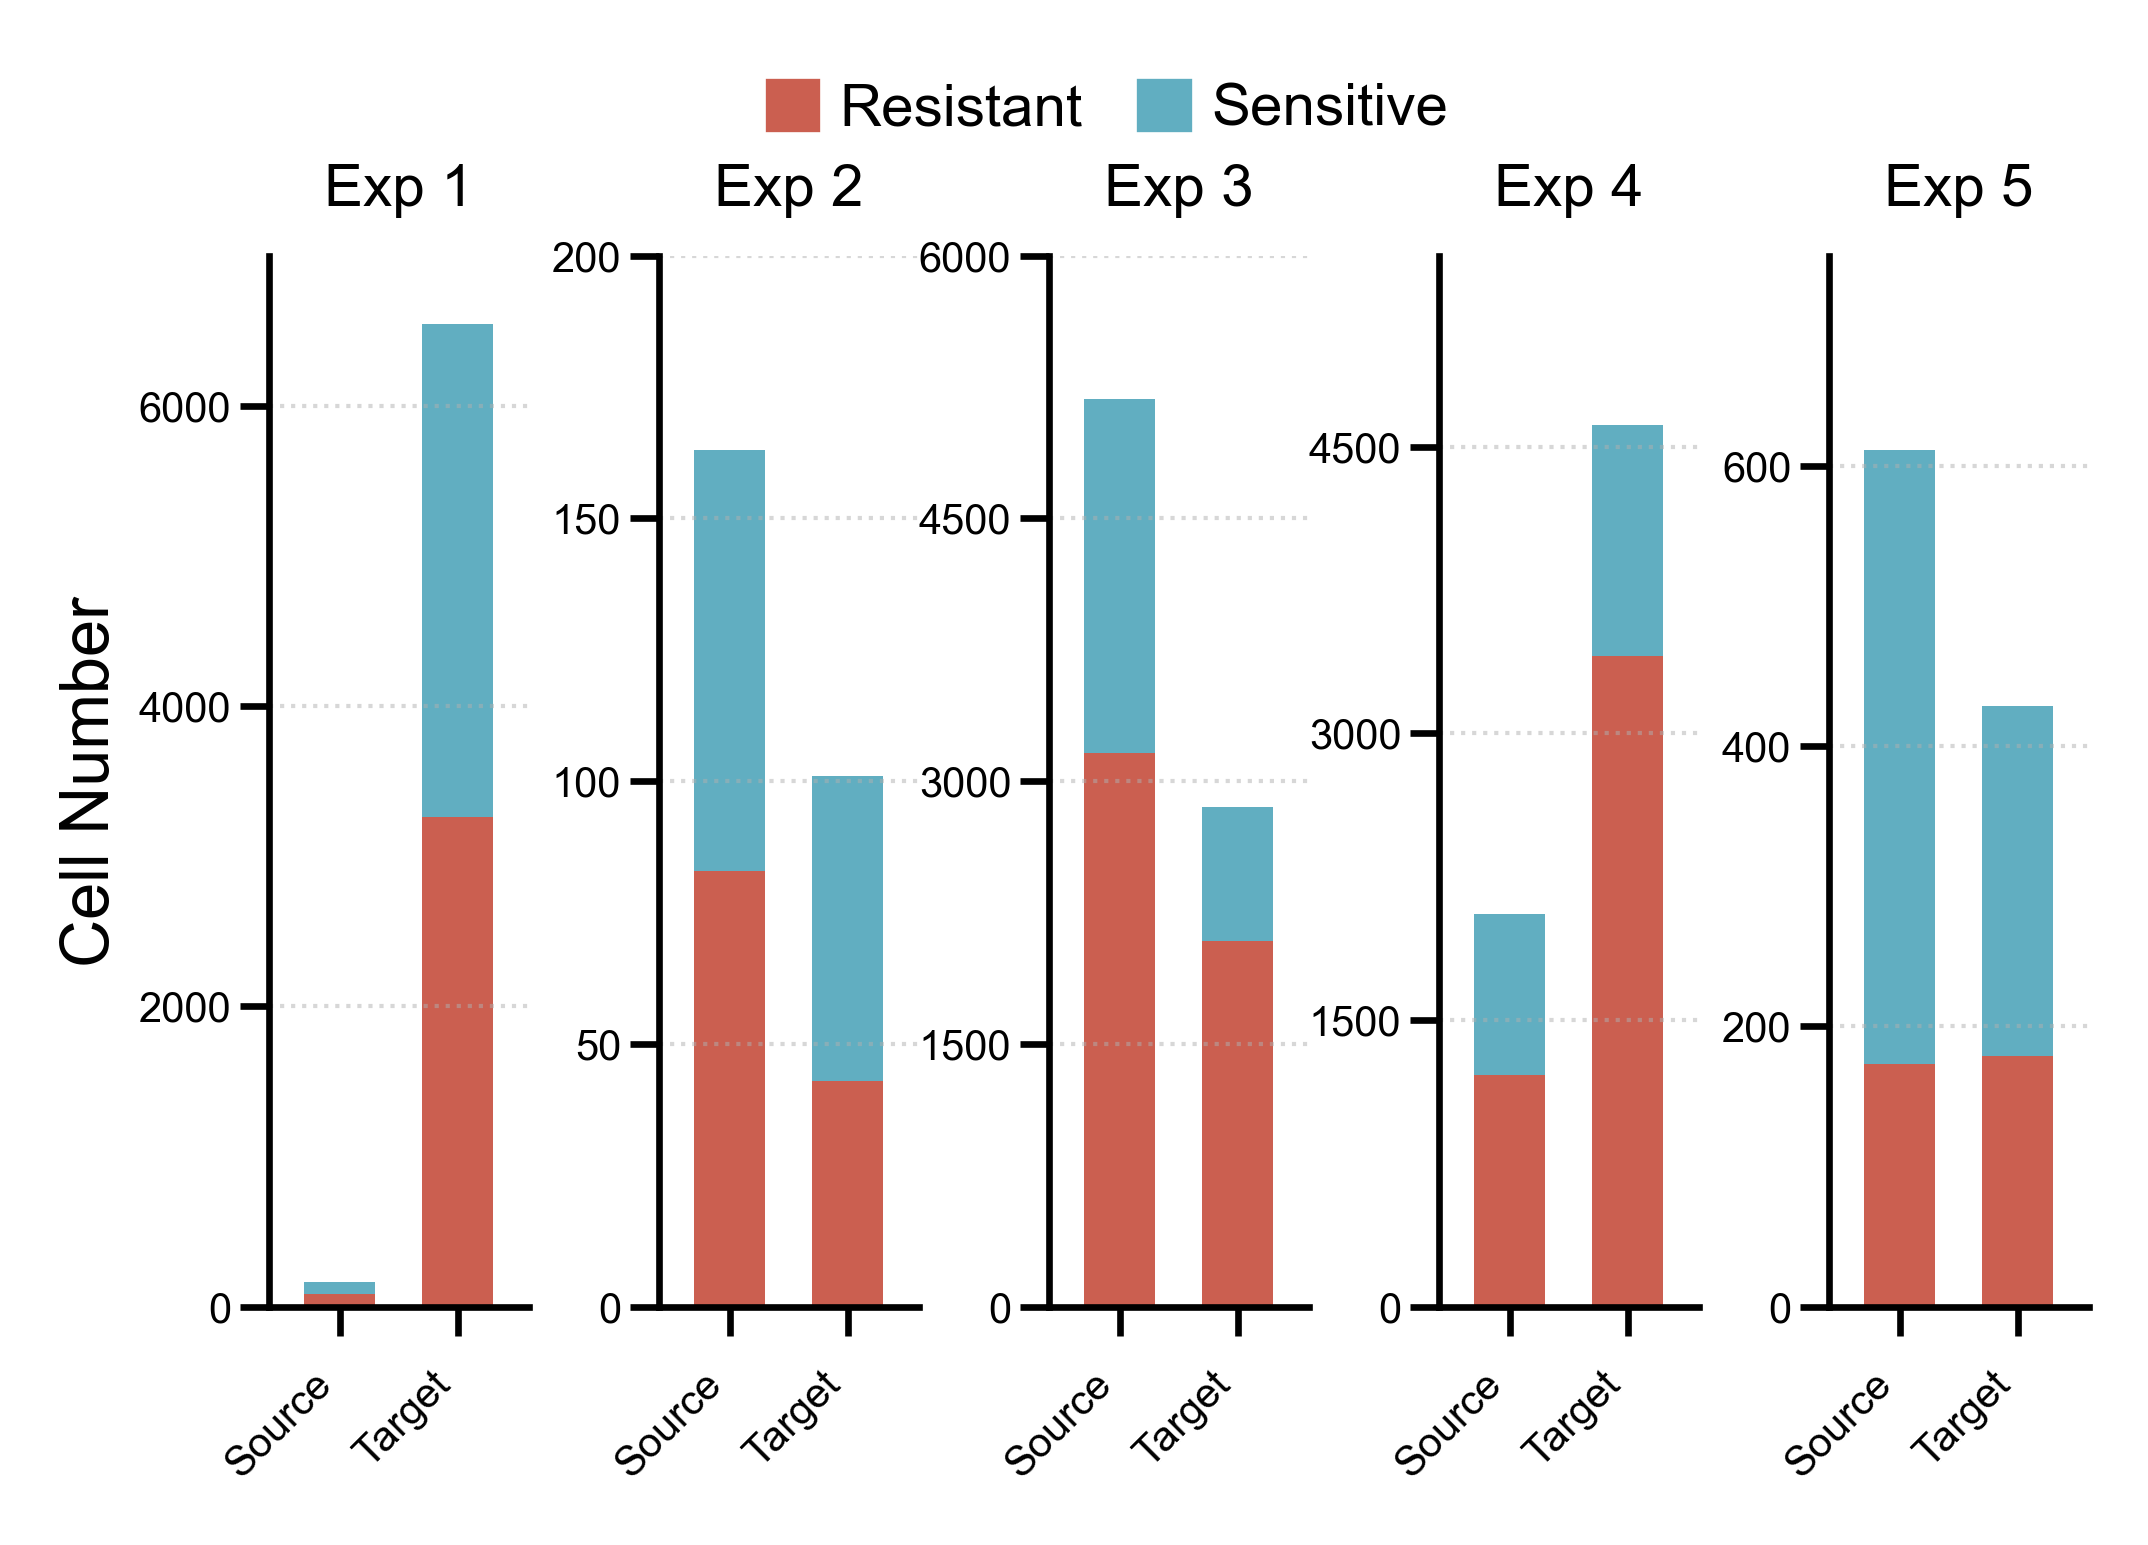

In [22]:
def plot_DatasetSampleDistribution():
    print(f'\n>>> Running Task: DatasetSampleDistribution...')
    plt.close('all')
    set_style()
    
    SHOW_VALUES = False
    SATURATION_FACTOR = 0.7
    
    experiments = [
        {
            "title": "Exp1: Cross-Platform",
            "ref_counts": [83, 80],
            "qry_counts": [3262, 3286],
        },
        {
            "title": "Exp2: Cross-Cell Line",
            "ref_counts": [83, 80],
            "qry_counts": [43, 58],
        },
        {
            "title": "Exp3: Cross-Tissue (Monotherapy)",
            "ref_counts": [3161, 2022],
            "qry_counts": [2086, 765],
        },
        {
            "title": "Exp4: Cross-Tissue (Combination)",
            "ref_counts": [1213, 840],
            "qry_counts": [3404, 1208],
        },
        {
            "title": "Exp5: Cross-Metastasis",
            "ref_counts": [173, 438],
            "qry_counts": [179, 250],
        },
    ]
    
    ylim_settings = [7000, 200, 6000, 5500, 750]
    
    COLOR_RESISTANT = adjust_saturation(Theme.Red.medium, SATURATION_FACTOR)
    COLOR_SENSITIVE = adjust_saturation(Theme.Blue.medium, SATURATION_FACTOR)
    
    set_style()
    
    fig, axes = plt.subplots(1, len(experiments), figsize=get_figsize(width='single', aspect=3.33/2.5))
    
    BAR_WIDTH = 0.6
    
    for i, (ax, exp) in enumerate(zip(axes, experiments)):
        print(f"Processing: {exp['title'].splitlines()[0]}")
    
        ref_counts = exp["ref_counts"]
        qry_counts = exp["qry_counts"]
    
        ax.bar(0, ref_counts[0], color=COLOR_RESISTANT, width=BAR_WIDTH, label='Resistant')
        ax.bar(0, ref_counts[1], bottom=ref_counts[0], color=COLOR_SENSITIVE, width=BAR_WIDTH, label='Sensitive')
    
        ax.bar(1, qry_counts[0], color=COLOR_RESISTANT, width=BAR_WIDTH)
        ax.bar(1, qry_counts[1], bottom=qry_counts[0], color=COLOR_SENSITIVE, width=BAR_WIDTH)
    
        if SHOW_VALUES:
            threshold = ylim_settings[i] * 0.05
    
            def plot_stack_labels(x, counts):
                bottom_val = counts[0]
                top_val = counts[1]
                total_h = bottom_val + top_val
    
                outside_labels = []
    
                if bottom_val > threshold:
                     ax.text(x, bottom_val/2, str(bottom_val), ha='center', va='center', fontsize=4, color='white')
                else:
                     if bottom_val > 0:
                        outside_labels.append(bottom_val)
    
                if top_val > threshold:
                     ax.text(x, bottom_val + top_val/2, str(top_val), ha='center', va='center', fontsize=4, color='black')
                else:
                     if top_val > 0:
                        outside_labels.append(top_val)
    
                if outside_labels:
                    y_pos = total_h + (ylim_settings[i] * 0.02)
                    step = ylim_settings[i] * 0.04
                    for val in outside_labels:
                        ax.text(x, y_pos, str(val), ha='center', va='bottom', fontsize=4, color='black')
                        y_pos += step
    
            plot_stack_labels(0, ref_counts)
            plot_stack_labels(1, qry_counts)
    
        ax.set_xticks([0, 1])
        ax.set_xticklabels(
            ["Source", "Target"],
            fontsize=5,
            rotation=45,
            ha='right'
        )
        ax.set_xlim(-0.6, 1.6)
    
        ax.set_title(f"Exp {i+1}", fontsize=7, pad=6)
        ax.set_ylim(0, ylim_settings[i])
    
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=5, pad=1)
    
        ax.grid(axis="y", linestyle=":", alpha=0.5, linewidth=0.5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='x', direction='out')
    
    axes[0].set_ylabel("Cell Number", fontsize=FONT_SIZE_LABEL, labelpad=2)
    
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=COLOR_RESISTANT),
        plt.Rectangle((0, 0), 1, 1, color=COLOR_SENSITIVE),
    ]
    fig.legend(handles, ["Resistant", "Sensitive"],
               loc="upper center",
               ncol=2,
               fontsize=FONT_SIZE_LEGEND,
               handlelength=0.8,
               handleheight=0.8,
               handletextpad=0.4,
               columnspacing=1.0,
               frameon=False,
               bbox_to_anchor=(0.5, 0.97))
    
    plt.subplots_adjust(
        left=0.08,
        bottom=0.12,
        right=0.99,
        top=0.82,
        wspace=0.5
    )
    
    global_saver.save(fig, "DatasetSampleDistribution", "Figure_Dataset_Sample_Distribution", dpi=DPI_DEFAULT)

plot_DatasetSampleDistribution()

# Gene Importance Plot

In [23]:
def plot_GeneImportance():
    print(f'\n>>> Running Task: GeneImportance...')
    plt.close('all')
    set_style()
    
    CONFIG = {
        "drug_name": "cisplatin",
        "data_root": DATA_ROOT / "GeneImportance",
        "output_dir": OUTPUT_ROOT,
        "top_k": 20,
        "saturation": 1.0
    }
    FORMATS = ['png']
    if SAVE_VECTOR:
        FORMATS.extend(['pdf', 'svg'])
    
    def plot_gene_importance(data_root, drug_name, output_dir, filename_base, top_k=20):
        print(f"Generating Gene Importance Plot for {drug_name}...")
    
        csv_path = data_root / f"gene_importance_stacked_{drug_name}.csv"
        if not csv_path.exists():
            print(f"[Error] CSV not found: {csv_path}")
            return
    
        df = pd.read_csv(csv_path)
        if not {'Gene', 'Class', 'Importance'}.issubset(df.columns):
            print("[Error] CSV format incorrect.")
            return
    
        df_pivot = df.pivot(index='Gene', columns='Class', values='Importance').fillna(0)
        df_pivot['Total'] = df_pivot.sum(axis=1)
        df_pivot = df_pivot.sort_values(by='Total', ascending=False).head(top_k)
        df_plot = df_pivot.drop(columns=['Total'])
    
        cols_order = ['Sensitive', 'Resistant']
        for col in cols_order:
            if col not in df_plot.columns:
                df_plot[col] = 0
        df_plot = df_plot[cols_order]
    
        saturation = CONFIG.get('saturation', 1.0)
        colors = [
            adjust_saturation(Theme.SOTA.medium, saturation),
            adjust_saturation(Theme.Ours.medium, saturation)
        ]
    
        fig, ax = plt.subplots(figsize=get_figsize(width='single', height=top_k * 0.12 + 0.6))
    
        df_plot.plot(kind='barh', stacked=True, color=colors, width=0.6,
                     edgecolor='black', linewidth=0.4, ax=ax)
    
        ax.set_xlabel("Mean |IG Score|", fontsize=FONT_SIZE_LABEL, fontweight='bold')
        ax.set_ylabel("")
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
        ax.invert_yaxis()
    
        ax.legend(title="Contribution", loc='lower right', fontsize=FONT_SIZE_LEGEND)
    
        plt.subplots_adjust(left=0.25, top=0.98)
    
        global_saver.save(fig, "GeneImportance", filename_base, bbox_inches='tight')
    
        plt.close('all')
    
    set_style()
    plot_gene_importance(CONFIG["data_root"], CONFIG["drug_name"],
                        CONFIG["output_dir"], "gene_importance_stacked", CONFIG["top_k"])

plot_GeneImportance()


>>> Running Task: GeneImportance...
Generating Gene Importance Plot for cisplatin...


# Heatmap Plot

In [24]:
@safe_plot
def plot_Heatmap():
    print(f'\n>>> Running Task: Heatmap...')
    plt.close('all')
    set_style()
    
    CONFIG = {
        "drug_name": "cisplatin",
        "data_root": DATA_ROOT / "Heatmap",
        "output_file": OUTPUT_ROOT / "heatmap_minimalist"
    }
    
    VIZ_CONFIG = {
        "figure": {
            "figsize": get_figsize(width='single', aspect=1.15),
            "dpi": DPI_DEFAULT,
            "formats": ["png", "pdf", "svg"],
            "width_ratios": [3.2, 10, 1.2],
            "height_ratios": [0.25, 10],
            "wspace": 0.12,
            "hspace": 0.02
        },
        "text": {
            "header_size": 7,
            "gene_label_size": 6,
            "legend_label_size": 7,
            "colorbar_text_size": 6
        },
        "style": {
            "divider_lw": 0.5,
            "group_marker_lw": 2.0,
            "top_bar_height": 0.8,
            "saturation": 1.0
        }
    }
    
    def prepare_data(data_root_path, drug_name):
        cache_file = data_root_path / f"cache_plot_data_{drug_name}.pkl"
    
        if cache_file.exists():
            pass
            try:
                with open(cache_file, 'rb') as f:
                    return pickle.load(f)
            except Exception as e:
                print(f"[Error] Cache load failed ({e}).")
                return None, None, None, None, None
        else:
            print(f"[Error] Cache file not found at {cache_file}.")
            return None, None, None, None, None
    
    def apply_row_zscore(data):
        data_zscore = np.zeros_like(data, dtype=float)
    
        for i in range(data.shape[0]):
            row = data[i, :]
            row_mean = np.nanmean(row)
            row_std = np.nanstd(row)
    
            if row_std == 0 or np.isnan(row_std):
                data_zscore[i, :] = 0
            else:
                data_zscore[i, :] = (row - row_mean) / row_std
    
        data_zscore = np.nan_to_num(data_zscore, nan=0.0)
    
        return data_zscore
    
    def sort_columns_within_groups(data, split_idx, n_sens):
        data_sorted = data.copy()
    
        if split_idx < data.shape[0] and n_sens > 0:
            sens_cells = data[split_idx:, :n_sens]
            sens_mean = np.nanmean(sens_cells, axis=0)
            sens_order = np.argsort(sens_mean)
            data_sorted[:, :n_sens] = data[:, sens_order]
    
        if split_idx > 0 and n_sens < data.shape[1]:
            res_cells = data[:split_idx, n_sens:]
            res_mean = np.nanmean(res_cells, axis=0)
            res_order = np.argsort(res_mean) + n_sens
            data_sorted[:, n_sens:] = data[:, res_order]
    
        return data_sorted
    
    def plot_heatmap_minimalist(data_tuple, output_dir, filename_base):
        data, labels, genes, split_idx, n_sens = data_tuple
    
        if data is None:
            print("[Error] No data to plot.")
            return
    
        n_genes, n_cells = data.shape
        n_res = n_cells - n_sens
    
        print(f"Plotting Minimalist Heatmap...")
    
        pass
        data = apply_row_zscore(data)
    
        pass
        data = sort_columns_within_groups(data, split_idx, n_sens)
    
        saturation = VIZ_CONFIG['style']['saturation']
        COLOR_SEN = adjust_saturation(Theme.SOTA.medium, saturation)
        COLOR_RES = adjust_saturation(Theme.Ours.medium, saturation)
    
        cmap_heatmap = 'RdBu_r'
    
        fig = plt.figure(figsize=VIZ_CONFIG['figure']['figsize'])
    
        gs = gridspec.GridSpec(2, 3,
                               width_ratios=VIZ_CONFIG['figure']['width_ratios'],
                               height_ratios=VIZ_CONFIG['figure']['height_ratios'],
                               wspace=VIZ_CONFIG['figure']['wspace'],
                               hspace=VIZ_CONFIG['figure']['hspace'])
    
        ax_gene_labels = fig.add_subplot(gs[1, 0])
        ax_bar = fig.add_subplot(gs[0, 1])
        ax_hm = fig.add_subplot(gs[1, 1])
        ax_leg = fig.add_subplot(gs[1, 2])
    
        bar_img = np.zeros((1, n_cells, 3))
        bar_img[:, :n_sens, :] = mcolors.to_rgb(COLOR_SEN)
        bar_img[:, n_sens:, :] = mcolors.to_rgb(COLOR_RES)
    
        ax_bar.imshow(bar_img, aspect='auto')
        ax_bar.set_axis_off()
    
        header_fontsize = VIZ_CONFIG['text']['header_size']
        ax_bar.text(n_sens / 2, -0.5, f"Sensitive (n={n_sens})", ha='center', va='bottom',
                    fontsize=header_fontsize, fontweight='bold', color=COLOR_SEN)
        ax_bar.text(n_sens + n_res / 2, -0.5, f"Resistant (n={n_res})", ha='center', va='bottom',
                    fontsize=header_fontsize, fontweight='bold', color=COLOR_RES)
    
        sns.heatmap(
            data,
            ax=ax_hm,
            cmap=cmap_heatmap,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            vmin=-2, vmax=2, center=0,
            linewidths=0,
        )
    
        if 0 < split_idx < n_genes:
            ax_hm.axhline(split_idx, color='white',
                          linewidth=2.0, linestyle='-', zorder=10)
        ax_hm.axvline(n_sens, color='white',
                      linewidth=2.0, linestyle='-', zorder=10)
    
        ax_gene_labels.set_ylim(n_genes, 0)
        ax_gene_labels.set_xlim(-0.3, 1)
        ax_gene_labels.set_axis_off()
    
        line_x = 0.15
        label_x = -0.12
    
        if split_idx > 0:
            ax_gene_labels.plot([line_x, line_x], [0, split_idx],
                               color=COLOR_RES, linewidth=VIZ_CONFIG['style']['group_marker_lw'],
                               solid_capstyle='butt', zorder=3)
            ax_gene_labels.text(label_x, split_idx / 2, "Resistant Markers",
                               ha='center', va='center', rotation=90,
                               fontsize=VIZ_CONFIG['text']['legend_label_size'],
                               fontweight='bold', color=COLOR_RES)
        if split_idx < n_genes:
            ax_gene_labels.plot([line_x, line_x], [split_idx, n_genes],
                               color=COLOR_SEN, linewidth=VIZ_CONFIG['style']['group_marker_lw'],
                               solid_capstyle='butt', zorder=3)
            ax_gene_labels.text(label_x, split_idx + (n_genes - split_idx) / 2, "Sensitive Markers",
                               ha='center', va='center', rotation=90,
                               fontsize=VIZ_CONFIG['text']['legend_label_size'],
                               fontweight='bold', color=COLOR_SEN)
    
        text_x = line_x + 0.08
        for i, gene in enumerate(genes):
            ax_gene_labels.text(text_x, i + 0.5, gene, ha='left', va='center',
                               fontsize=VIZ_CONFIG['text']['gene_label_size'],
                               fontweight='normal', color='black')
    
        ax_leg.set_axis_off()
        ax_leg.set_xlim(0, 1)
        ax_leg.set_ylim(0, 1)
    
        cax = ax_leg.inset_axes([0.45, 0.30, 0.25, 0.40])
        norm = plt.Normalize(-2, 2)
        sm = plt.cm.ScalarMappable(cmap=cmap_heatmap, norm=norm)
        sm.set_array([])
    
        cbar = plt.colorbar(sm, cax=cax)
        cbar.set_ticks([-2, 0, 2])
        cbar.set_ticklabels(['-2', '0', '+2'], fontsize=FONT_SIZE_SUB_TICK)
        cbar.outline.set_linewidth(0.5)
    
        ax_leg.text(0.575, 0.75, "Row\nZ-Score", ha='center',
                    fontsize=VIZ_CONFIG['text']['colorbar_text_size'], style='italic')
    
        global_saver.save(None, "Heatmap", filename_base,
                          dpi=VIZ_CONFIG['figure']['dpi'],
                          bbox_inches='tight',
                          pad_inches=0.02)
    
        print(f"\n[Success] Minimalist Heatmap saved to: {OUTPUT_ROOT / 'png' / 'Heatmap'}")
        plt.close('all')
    
    set_style()
    
    data_tuple = prepare_data(CONFIG["data_root"], CONFIG["drug_name"])
    
    if data_tuple[0] is not None:
        output_dir = CONFIG["output_file"].parent
        filename_base = CONFIG["output_file"].stem
        plot_heatmap_minimalist(data_tuple, output_dir, filename_base)

plot_Heatmap()


>>> Running Task: Heatmap...
Plotting Minimalist Heatmap...

[Success] Minimalist Heatmap saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output\png\Heatmap


# Rose Chart: Cleveland Comparison

In [25]:
@safe_plot
def plot_RoseChart_ClevelandComparison():
    print(f'\n>>> Running Task: RoseChart_ClevelandComparison...')
    plt.close('all')
    set_style()
    
    VIZ_CONFIG = {
        "figure": {
            "figsize": get_figsize(width='double', height=1.4),
            "dpi": DPI_DEFAULT,
            "formats": ["png", "pdf", "svg"],
            "wspace": 0.25,
            "hspace": 0.1,
            "legend_pos": (0.5, 0.98),
            "margins": {
                "rose": {"top": 0.76, "bottom": 0.08, "left": 0.06, "right": 0.80},
                "violin": {"top": 0.85, "bottom": 0.22, "left": 0.84, "right": 0.98}
            }
        },
        "style": {
            "bar_width_ratio": 0.8,
            "alpha": 1.0,
            "grid_alpha": 0.3,
            "linewidth": 0.6
        },
        "text": {
            "xtick_size": FONT_SIZE_TICK,
            "value_label_size": FONT_SIZE_VALUE_SMALL,
            "violin_ylabel_size": FONT_SIZE_LABEL,
            "violin_xtick_size": FONT_SIZE_SUB_TICK,
            "legend_size": FONT_SIZE_LEGEND
        }
    }
    
    save_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "output")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    LANGUAGE = "en"
    SHOW_TITLE = False
    SHOW_VALUES = True
    
    LABELS = {
        "cn": {
            "datasets": ["实验1：PLX4720", "实验2：PLX4720_A375", "实验3：Paclitaxel", "实验4：Pac+Ate", "实验5：Cisplatin"],
            "groups": ["CE+Overlap (Ours)", "Only CE", "Only Overlap"],
            "metrics": ["ACC", "F1-macro", "AUC", "AUPR"],
            "violin_title": "整体性能分布分析",
            "main_title": "Cleveland 数据集对比分析",
            "violin_ylabel": "AUC"
        },
        "en": {
            "datasets": [
                "Exp1: PLX4720",
                "Exp2: PLX4720_A375",
                "Exp3: Paclitaxel",
                "Exp4: Pac+Ate",
                "Exp5: Cisplatin"
            ],
            "groups": [
                "CE+Overlap",
                "Only CE",
                "Only Overlap"
            ],
            "metrics": ["ACC", "F1-macro", "AUC", "AUPR"],
            "violin_title": "Overall Performance Distribution",
            "main_title": "Comparison of Cleveland Datasets",
            "violin_ylabel": "AUC"
        }
    }
    
    set_style()
    plt.rcParams['figure.constrained_layout.use'] = False
    
    if LANGUAGE == "cn":
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial', 'DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
    else:
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
    current_labels = LABELS[LANGUAGE]
    datasets = current_labels["datasets"]
    metrics = current_labels["metrics"]
    groups = current_labels["groups"]
    colors = [Theme.Ours.medium, Theme.SOTA.medium, Theme.Baseline.medium]
    
    d1 = [[0.994, 0.994, 0.999, 0.999], [0.989, 0.989, 0.991, 0.995], [0.989, 0.989, 0.982, 0.960]]
    d2 = [[0.891, 0.890, 0.931, 0.952], [0.782, 0.782, 0.816, 0.870], [0.811, 0.811, 0.877, 0.925]]
    d3 = [[0.857, 0.846, 0.924, 0.885], [0.839, 0.832, 0.836, 0.819], [0.610, 0.381, 0.906, 0.874]]
    d4 = [[0.912, 0.907, 0.970, 0.964], [0.764, 0.720, 0.894, 0.877], [0.591, 0.374, 0.906, 0.849]]
    d5 = [[0.882, 0.873, 0.966, 0.957], [0.768, 0.721, 0.927, 0.921], [0.848, 0.836, 0.954, 0.969]]
    all_data = [d1, d2, d3, d4, d5]
    
    violin_rows = []
    auc_idx = metrics.index("AUC")
    for ds_idx, ds_data in enumerate(all_data):
        for grp_idx, grp_data in enumerate(ds_data):
            val = grp_data[auc_idx]
            violin_rows.append({"Dataset": datasets[ds_idx], "Method": groups[grp_idx], "Value": val})
    df_violin = pd.DataFrame(violin_rows)
    
    fig = plt.figure(figsize=VIZ_CONFIG['figure']['figsize'], constrained_layout=False)
    
    rose_m = VIZ_CONFIG['figure']['margins']['rose']
    gs_rose = gridspec.GridSpec(1, 5, figure=fig,
                               wspace=VIZ_CONFIG['figure']['wspace'],
                               top=rose_m['top'],
                               bottom=rose_m['bottom'],
                               left=rose_m['left'],
                               right=rose_m['right'])
    
    violin_m = VIZ_CONFIG['figure']['margins']['violin']
    gs_violin = gridspec.GridSpec(1, 1, figure=fig,
                                 top=violin_m['top'],
                                 bottom=violin_m['bottom'],
                                 left=violin_m['left'],
                                 right=violin_m['right'])
    
    num_metrics = len(metrics)
    num_groups = len(groups)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)
    total_width = 2 * np.pi / num_metrics
    bar_width = (total_width * VIZ_CONFIG['style']['bar_width_ratio']) / num_groups
    
    for i in range(5):
        dataset_name = datasets[i]
        data = all_data[i]
    
        ax = fig.add_subplot(gs_rose[0, i], projection='polar')
        draw_rose_core(ax, data, angles, bar_width, colors, groups, metrics, SHOW_VALUES, VIZ_CONFIG)
    
        sub_fig = plt.figure(figsize=(1.0, 1.0), layout=None)
        sub_ax = sub_fig.add_subplot(111, projection='polar')
        draw_rose_core(sub_ax, data, angles, bar_width, colors, groups, metrics, SHOW_VALUES, VIZ_CONFIG)
    
        sub_filename = f"Rose_Chart_{i+1}_{dataset_name.replace(':', '').replace(' ', '_')}"
        global_saver.save(sub_fig, "RoseChart_ClevelandComparison", sub_filename, sub_folder="subplots",
                          bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
        plt.close(sub_fig)
    
    ax_violin = fig.add_subplot(gs_violin[0, 0])
    draw_violin_core(ax_violin, df_violin, colors, groups, VIZ_CONFIG, y_ticks=[0.8, 0.9, 1.0], y_lim=[0.75, 1.02])
    
    sub_fig_v = plt.figure(figsize=(1.0, 1.0), layout=None)
    sub_ax_v = sub_fig_v.add_subplot(111)
    draw_violin_core(sub_ax_v, df_violin, colors, groups, VIZ_CONFIG, y_ticks=[0.8, 0.9, 1.0], y_lim=[0.75, 1.02])
    
    sub_filename_v = "Overall_Violin_Distribution"
    global_saver.save(sub_fig_v, "RoseChart_ClevelandComparison", sub_filename_v, sub_folder="subplots",
                      bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
    plt.close(sub_fig_v)
    
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=group, linewidth=0)
                       for color, group in zip(colors, groups)]
    
    fig.legend(handles=legend_elements, loc='upper center', ncol=3, frameon=False,
               fontsize=VIZ_CONFIG['text']['legend_size'],
               bbox_to_anchor=VIZ_CONFIG['figure']['legend_pos'])
    
    filename_base = "Mixed_Chart_Final_Refactored"
    global_saver.save(fig, "RoseChart_ClevelandComparison", filename_base,
                      bbox_inches='tight', pad_inches=0.01, dpi=VIZ_CONFIG['figure']['dpi'])
    
    pass
    print(f"[Success] Final adjustment completed! Language: {LANGUAGE.upper()}")
    pass
    pass
    pass
    pass
    print(f"Saved to: {save_dir}")
    pass
    
    plt.close('all')

plot_RoseChart_ClevelandComparison()


>>> Running Task: RoseChart_ClevelandComparison...
[Error] Failed running plot_RoseChart_ClevelandComparison: name '__file__' is not defined


Traceback (most recent call last):
  File "C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\1930819848.py", line 16, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\1290685200.py", line 35, in plot_RoseChart_ClevelandComparison
    save_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "output")
NameError: name '__file__' is not defined


# Rose Chart: Graph Construction

In [26]:
@safe_plot
def plot_RoseChart_GraphConstruction():
    print(f'\n>>> Running Task: RoseChart_GraphConstruction...')
    plt.close('all')
    set_style()
    
    VIZ_CONFIG = {
        "figure": {
            "figsize": get_figsize(width='double', height=1.4),
            "dpi": DPI_DEFAULT,
            "formats": ["png", "pdf", "svg"],
            "wspace": 0.25,
            "hspace": 0.1,
            "legend_pos": (0.5, 0.98),
            "margins": {
                "rose": {"top": 0.76, "bottom": 0.08, "left": 0.06, "right": 0.80},
                "violin": {"top": 0.85, "bottom": 0.22, "left": 0.84, "right": 0.98}
            }
        },
        "style": {
            "bar_width_ratio": 0.8,
            "alpha": 1.0,
            "grid_alpha": 0.3,
            "linewidth": 0.6
        },
        "text": {
            "xtick_size": FONT_SIZE_TICK,
            "value_label_size": FONT_SIZE_VALUE_SMALL,
            "violin_ylabel_size": FONT_SIZE_LABEL,
            "violin_xtick_size": FONT_SIZE_SUB_TICK,
            "legend_size": FONT_SIZE_LEGEND
        }
    }
    
    save_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "output")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    LANGUAGE = "en"
    SHOW_TITLE = False
    SHOW_VALUES = True
    
    LABELS = {
        "cn": {
            "datasets": ["实验1：跨测序平台", "实验2：跨细胞系", "实验3：单药跨组织", "实验4：联合用药跨组织", "实验5：跨转移状态"],
            "groups": ["CSGDA (Ours)", "KNN构图", "Pearson构图", "Spearman构图"],
            "metrics": ["ACC", "F1-macro", "AUC", "AUPR"],
            "violin_title": "整体性能分布分析",
            "main_title": "图结构学习与静态构图策略的对比",
            "violin_ylabel": "AUC"
        },
        "en": {
            "datasets": [
                "Exp1: Cross-Platform",
                "Exp2: Cross-Cell Line",
                "Exp3: Cross-Tissue (Monotherapy)",
                "Exp4: Cross-Tissue (Combination)",
                "Exp5: Cross-Metastasis"
            ],
            "groups": [
                "CSGDA",
                "KNN",
                "Pearson",
                "Spearman"
            ],
            "metrics": ["ACC", "F1-macro", "AUC", "AUPR"],
            "violin_title": "Overall Performance Distribution",
            "main_title": "Comparison of Graph Structure Learning Strategies",
            "violin_ylabel": "AUC"
        }
    }
    
    set_style()
    plt.rcParams['figure.constrained_layout.use'] = False
    
    if LANGUAGE == "cn":
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial', 'DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
    else:
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
    current_labels = LABELS[LANGUAGE]
    datasets = current_labels["datasets"]
    metrics = current_labels["metrics"]
    groups = current_labels["groups"]
    colors = [Theme.Red.medium, Theme.Blue.dark, Theme.Blue.medium, Theme.Blue.light]
    
    d1 = [[0.9947, 0.9947, 0.9999, 0.9999], [0.9861, 0.9861, 0.9991, 0.9991], [0.9724, 0.9723, 0.9973, 0.9968],
          [0.9885, 0.9885, 0.9985, 0.9989]]
    d2 = [[0.8911, 0.8907, 0.9310, 0.9527], [0.8416, 0.8893, 0.9391, 0.8414], [0.7129, 0.7899, 0.8381, 0.6925],
          [0.6337, 0.6117, 0.7747, 0.8623]]
    d3 = [[0.8576, 0.8462, 0.9245, 0.8850], [0.8441, 0.8345, 0.8819, 0.8491], [0.8026, 0.7994, 0.8320, 0.7065],
          [0.8173, 0.7963, 0.8550, 0.8360]]
    d4 = [[0.9123, 0.9077, 0.9707, 0.9643], [0.8422, 0.8259, 0.9554, 0.9364], [0.7988, 0.7682, 0.8832, 0.8708],
          [0.7540, 0.7008, 0.8727, 0.8507]]
    d5 = [[0.8826, 0.8735, 0.9662, 0.9571], [0.7995, 0.7954, 0.8712, 0.9168], [0.7040, 0.6457, 0.8760, 0.9195],
          [0.7016, 0.6387, 0.8140, 0.8364]]
    all_data = [d1, d2, d3, d4, d5]
    
    violin_rows = []
    auc_idx = metrics.index("AUC")
    for ds_idx, ds_data in enumerate(all_data):
        for grp_idx, grp_data in enumerate(ds_data):
            val = grp_data[auc_idx]
            violin_rows.append({"Dataset": datasets[ds_idx], "Method": groups[grp_idx], "Value": val})
    df_violin = pd.DataFrame(violin_rows)
    
    fig = plt.figure(figsize=VIZ_CONFIG['figure']['figsize'], constrained_layout=False)
    
    rose_m = VIZ_CONFIG['figure']['margins']['rose']
    gs_rose = gridspec.GridSpec(1, 5, figure=fig,
                               wspace=VIZ_CONFIG['figure']['wspace'],
                               top=rose_m['top'],
                               bottom=rose_m['bottom'],
                               left=rose_m['left'],
                               right=rose_m['right'])
    
    violin_m = VIZ_CONFIG['figure']['margins']['violin']
    gs_violin = gridspec.GridSpec(1, 1, figure=fig,
                                 top=violin_m['top'],
                                 bottom=violin_m['bottom'],
                                 left=violin_m['left'],
                                 right=violin_m['right'])
    
    num_metrics = len(metrics)
    num_groups = len(groups)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)
    total_width = 2 * np.pi / num_metrics
    bar_width = (total_width * VIZ_CONFIG['style']['bar_width_ratio']) / num_groups
    
    for i in range(5):
        dataset_name = datasets[i]
        data = all_data[i]
    
        ax = fig.add_subplot(gs_rose[0, i], projection='polar')
        draw_rose_core(ax, data, angles, bar_width, colors, groups, metrics, SHOW_VALUES, VIZ_CONFIG)
    
        sub_fig = plt.figure(figsize=(1.0, 1.0), layout=None)
        sub_ax = sub_fig.add_subplot(111, projection='polar')
        draw_rose_core(sub_ax, data, angles, bar_width, colors, groups, metrics, SHOW_VALUES, VIZ_CONFIG)
    
        sub_filename = f"Rose_Chart_{i+1}_{dataset_name.replace(':', '').replace(' ', '_')}"
        global_saver.save(sub_fig, "RoseChart_GraphConstruction", sub_filename, sub_folder="subplots",
                          bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
        plt.close(sub_fig)
    
    ax_violin = fig.add_subplot(gs_violin[0, 0])
    draw_violin_core(ax_violin, df_violin, colors, groups, VIZ_CONFIG, y_ticks=[0.8, 0.9, 1.0], y_lim=[0.75, 1.02])
    
    sub_fig_v = plt.figure(figsize=(1.0, 1.0), layout=None)
    sub_ax_v = sub_fig_v.add_subplot(111)
    draw_violin_core(sub_ax_v, df_violin, colors, groups, VIZ_CONFIG, y_ticks=[0.8, 0.9, 1.0], y_lim=[0.75, 1.02])
    
    sub_filename_v = "Overall_Violin_Distribution"
    global_saver.save(sub_fig_v, "RoseChart_GraphConstruction", sub_filename_v, sub_folder="subplots",
                      bbox_inches='tight', pad_inches=0.01, dpi=DPI_DEFAULT)
    plt.close(sub_fig_v)
    
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=group, linewidth=0)
                       for color, group in zip(colors, groups)]
    
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, frameon=False,
               fontsize=VIZ_CONFIG['text']['legend_size'],
               bbox_to_anchor=VIZ_CONFIG['figure']['legend_pos'])
    
    filename_base = "Mixed_Chart_Final_Refactored"
    global_saver.save(fig, "RoseChart_GraphConstruction", filename_base,
                      bbox_inches='tight', pad_inches=0.01, dpi=VIZ_CONFIG['figure']['dpi'])
    
    pass
    print(f"[Success] Final adjustment completed! Language: {LANGUAGE.upper()}")
    pass
    pass
    pass
    pass
    print(f"Saved to: {save_dir}")
    pass
    
    plt.close('all')

plot_RoseChart_GraphConstruction()


>>> Running Task: RoseChart_GraphConstruction...
[Error] Failed running plot_RoseChart_GraphConstruction: name '__file__' is not defined


Traceback (most recent call last):
  File "C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\1930819848.py", line 16, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\918787938.py", line 35, in plot_RoseChart_GraphConstruction
    save_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "output")
NameError: name '__file__' is not defined


# Sankey Diagram: Gene-Phenotype

In [27]:
def plot_Sankey_GenePheno():
    print(f'\n>>> Running Task: Sankey_GenePheno...')
    plt.close('all')
    set_style()
    
    set_style()
    
    PX = 100
    VIZ_WIDTH = int(FIG_WIDTH_SINGLE * PX)
    VIZ_HEIGHT = int(VIZ_WIDTH * (550/333))
    
    VIZ_CONFIG = {
        "drug_name": "cisplatin",
        "figure": {
            "width": VIZ_WIDTH,
            "height": VIZ_HEIGHT,
            "font_size": 10,
            "scale": 3,
            "formats": ["png", "pdf", "svg"]
        },
        "node": {
            "pad": 20,
            "thickness": 20,
            "line_width": 0.5,
            "line_color": "white"
        },
        "link": {
            "default_opacity": 0.4,
            "use_csv_colors": False,
            "rules": [
                {
                    "source_group": "Response",
                    "target_group": "Gene",
                    "color_strategy": "source"
                },
                {
                    "source_group": "Gene",
                    "target_group": "Phenotype",
                    "color_strategy": "target"
                }
            ]
        },
        "annotations": [
            {"x": 0.0, "y": 1.08, "text": "Response", "size": 11, "weight": "bold"},
            {"x": 0.5, "y": 1.08, "text": "Key Genes", "size": 11, "weight": "bold"},
            {"x": 1.0, "y": 1.08, "text": "Cell States", "size": 11, "weight": "bold"}
        ],
        "nodes": [
            {"label": "Resistant", "color": Theme.Ours.medium, "group": "Response"},
            {"label": "Sensitive", "color": Theme.SOTA.medium, "group": "Response"},
            {"label": "RAD51C", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "EEF1A1", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "PAM", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "POLR2G", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "PSMD14", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "CETN2", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "NDUFA11", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "ERCC1", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "NDUFS6", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "MCM3", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "CRADD", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "SSRP1", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "MAD2L2", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "GNG10", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "UBR7", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "TMEM205", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "PFKP", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "GRPEL1", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "EXOSC1", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "F3", "color": Theme.Neutral.medium, "group": "Gene"},
            {"label": "Apoptosis", "color": Theme.Purple.medium, "group": "Phenotype"},
            {"label": "Cell Cycle", "color": Theme.Blue.medium, "group": "Phenotype"},
            {"label": "DNA damage", "color": Theme.Red.light, "group": "Phenotype"},
            {"label": "DNA repair", "color": Theme.Red.medium, "group": "Phenotype"},
            {"label": "EMT", "color": Theme.Green.medium, "group": "Phenotype"},
            {"label": "Hypoxia", "color": Theme.Orange.medium, "group": "Phenotype"},
            {"label": "Other", "color": Theme.Gray.light, "group": "Phenotype"},
            {"label": "Stemness", "color": Theme.Orange.light, "group": "Phenotype"}
        ]
    }
    
    class SankeyDiagram:
    
        def __init__(self, data_path: str):
            self.data_path = data_path
            self.df_links: Optional[pd.DataFrame] = None
            self.fig: Optional[go.Figure] = None
    
            self.load_data()
    
        def load_data(self):
            if not os.path.exists(self.data_path):
                raise FileNotFoundError(f"Data file not found: {self.data_path}")
    
            self.df_links = pd.read_csv(self.data_path)
            pass
    
        @staticmethod
        def _hex_to_rgba(hex_color: str, alpha: float = 0.4) -> str:
            hex_color = hex_color.lstrip('#')
            if len(hex_color) == 3:
                hex_color = ''.join([c*2 for c in hex_color])
    
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
            return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'
    
        def _compute_link_colors(self) -> List[str]:
            styling = VIZ_CONFIG.get('link', {})
            use_csv = styling.get('use_csv_colors', False)
    
            if use_csv and 'color' in self.df_links.columns:
                pass
                return self.df_links['color'].tolist()
    
            print("[Info] Generating dynamic link colors based on configuration...")
            default_opacity = styling.get('default_opacity', 0.4)
            rules = styling.get('rules', [])
            nodes = VIZ_CONFIG.get('nodes', [])
    
            colors = []
            for _, row in self.df_links.iterrows():
                source_idx = int(row['source'])
                target_idx = int(row['target'])
    
                if source_idx >= len(nodes) or target_idx >= len(nodes):
                    print(f"[Warning] Index out of bounds: {source_idx}->{target_idx}")
                    colors.append(f"rgba(128,128,128,{default_opacity})")
                    continue
    
                source_node = nodes[source_idx]
                target_node = nodes[target_idx]
    
                link_color = f"rgba(200,200,200,{default_opacity})"
    
                for rule in rules:
                    s_group = rule.get('source_group')
                    t_group = rule.get('target_group')
                    strategy = rule.get('color_strategy')
    
                    if (source_node.get('group') == s_group and
                        target_node.get('group') == t_group):
    
                        if strategy == 'source':
                            base_color = source_node.get('color', '#808080')
                        elif strategy == 'target':
                            base_color = target_node.get('color', '#808080')
                        else:
                            base_color = '#808080'
    
                        link_color = self._hex_to_rgba(base_color, default_opacity)
                        break
    
                colors.append(link_color)
    
            return colors
    
        def generate_plot(self):
            print("[Info] Generating Sankey diagram...")
    
            sources = self.df_links['source'].tolist()
            targets = self.df_links['target'].tolist()
            values = self.df_links['value'].tolist()
    
            link_colors = self._compute_link_colors()
    
            nodes = VIZ_CONFIG.get('nodes', [])
            node_labels = [n.get('label', 'Unknown') for n in nodes]
            node_colors = [n.get('color', '#808080') for n in nodes]
    
            self.fig = go.Figure(data=[go.Sankey(
                node=dict(
                    pad=VIZ_CONFIG['node']['pad'],
                    thickness=VIZ_CONFIG['node']['thickness'],
                    line=dict(color=VIZ_CONFIG['node']['line_color'], width=VIZ_CONFIG['node']['line_width']),
                    label=node_labels,
                    color=node_colors,
                    hovertemplate='%{label}<br>Total Score: %{value:.3f}<extra></extra>'
                ),
                link=dict(
                    source=sources,
                    target=targets,
                    value=values,
                    color=link_colors,
                    hovertemplate='Contribution: %{value:.3f}<extra></extra>'
                )
            )])
    
            annotations_cfg = VIZ_CONFIG.get('annotations', [])
    
            plotly_annotations = []
            for ann in annotations_cfg:
                plotly_annotations.append(dict(
                    x=ann.get('x'),
                    y=ann.get('y'),
                    text=f"<b>{ann.get('text')}</b>",
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    font=dict(
                        size=ann.get('size', 12)
                    )
                ))
    
            self.fig.update_layout(
                font_size=VIZ_CONFIG['figure'].get('font_size', 10),
                width=VIZ_CONFIG['figure'].get('width', 333),
                height=VIZ_CONFIG['figure'].get('height', 550),
                annotations=plotly_annotations,
                margin=dict(l=5, r=5, t=60, b=10),
                paper_bgcolor='white',
                plot_bgcolor='white'
            )
    
        def save_plot(self):
            filename_base = f"sankey_{VIZ_CONFIG.get('drug_name', 'unknown')}"
            scale = VIZ_CONFIG['figure'].get('scale', 1)
            width = VIZ_CONFIG['figure'].get('width', 1100)
            height = VIZ_CONFIG['figure'].get('height', 800)
            
            global_saver.save(self.fig, "Sankey_GenePheno", filename_base,
                              scale=scale, width=width, height=height)
    
    def main():
        script_dir = DATA_ROOT / "Sankey_GenePheno"
        DATA_DIR = script_dir / "data"
        
        data_file = script_dir / "sankey_links.csv"
        if not data_file.exists():
            data_file = DATA_DIR / "sankey_links.csv"
        
        try:
            sankey = SankeyDiagram(str(data_file))
            sankey.generate_plot()
            sankey.save_plot()
            
        except Exception as e:
            print(f"\n[Fatal Error] {str(e)}")
            import traceback
            traceback.print_exc()
    
    main()

plot_Sankey_GenePheno()


>>> Running Task: Sankey_GenePheno...
[Info] Generating Sankey diagram...
[Info] Generating dynamic link colors based on configuration...


# Sankey Diagram: Performance

In [28]:
@safe_plot
def plot_Sankey_Performance():
    print(f'\n>>> Running Task: Sankey_Performance...')
    plt.close('all')
    set_style()
    
    set_style()
    
    PX = 100
    VIZ_WIDTH = int(FIG_WIDTH_SINGLE * PX)
    VIZ_HEIGHT = int(VIZ_WIDTH * (140/210))
    
    SHOW_TITLE = False
    
    FONT_SIZE_TITLE = 18
    FONT_SIZE_TICKS = 14
    FONT_SIZE_VALUES = 16
    
    EXPERIMENTS_TO_RUN = [
        "Exp1_PLX4720",
        "Exp3_Paclitaxel",
        "Exp4_Pac_Ate",
    ]
    
    CONFIG = {
        "data_root": DATA_ROOT / "Sankey_Performance",
        "output_dir": OUTPUT_ROOT
    }
    
    EXP_TITLE_MAP = {
        "Exp1_PLX4720": "Exp1: Cross-Platform",
        "Exp2_PLX4720_A375": "Exp2: Cross-Cell Line",
        "Exp3_Paclitaxel": "Exp3: Cross-Tissue (Monotherapy)",
        "Exp4_Pac_Ate": "Exp4: Cross-Tissue (Combination)",
        "Exp5_Cisplatin": "Exp5: Cross-Metastasis"
    }
    
    VIZ_CONFIG = {
        "figure": {
            "width": VIZ_WIDTH,
            "height": VIZ_HEIGHT,
            "scale": 3,
            "formats": ["png", "pdf", "svg"]
        },
        "node": {
            "pad": 15,
            "thickness": 20,
            "line_width": 1
        },
        "link": {
            "alpha": 0.4
        }
    }
    
    def plot_sankey_perf(y_true, y_pred, title, output_dir, filename_base):
        print(f"Generating Sankey Performance Plot: {title}")
    
        labels = ["Ground Truth<br>Resistant", "Ground Truth<br>Sensitive", "Predicted<br>Resistant", "Predicted<br>Sensitive"]
    
        node_colors = [
            Theme.Ours.medium,
            Theme.SOTA.medium,
            Theme.Ours.medium,
            Theme.SOTA.medium
        ]
    
        sources = []
        targets = []
        values = []
        link_colors = []
    
        colors = [Theme.Ours.medium, Theme.SOTA.medium]
    
        for gt in [0, 1]:
            for pred in [0, 1]:
                count = int(np.sum((y_true == gt) & (y_pred == pred)))
                if count > 0:
                    sources.append(gt)
                    targets.append(pred + 2)
                    values.append(count)
                    link_colors.append(style_lib.hex_to_rgba(colors[gt], alpha=VIZ_CONFIG['link']['alpha']))
    
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=VIZ_CONFIG['node']['pad'],
                thickness=VIZ_CONFIG['node']['thickness'],
                line=dict(color="white", width=VIZ_CONFIG['node']['line_width']),
                label=labels,
                color=node_colors
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values,
                color=link_colors,
                hovertemplate='Source: %{source.label}<br />Target: %{target.label}<br />Count: %{value}<extra></extra>'
            )
        )])
    
        fig.update_layout(
            title_text=title.replace('\n', '<br>') if SHOW_TITLE else "",
            title_font=dict(size=FONT_SIZE_TITLE, color="black"),
            font=dict(size=FONT_SIZE_VALUES, color="black"),
            width=VIZ_CONFIG['figure']['width'],
            height=VIZ_CONFIG['figure']['height'],
            margin=dict(l=0, r=0, t=0, b=0)
        )
    
        global_saver.save(fig, "Sankey_Performance", filename_base, scale=VIZ_CONFIG['figure']['scale'])
    
        print(f"[Success] Sankey Performance plots saved to: {output_dir}")
    
    CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
    
    for exp_name in EXPERIMENTS_TO_RUN:
        print(f"\n>>> Processing Experiment: {exp_name}")
        exp_title = EXP_TITLE_MAP.get(exp_name, exp_name)
    
        data_file = CONFIG["data_root"] / f"{exp_name}_sankey.npz"
        if data_file.exists():
            try:
                data = np.load(data_file)
                y_true = next((data[k] for k in ['labels_t', 'labels', 'y_true'] if k in data), None)
                y_pred = next((data[k] for k in ['preds_t', 'predictions', 'y_pred'] if k in data), None)
    
                if y_true is not None and y_pred is not None:
                    title = f"Classification Performance Flow\n({exp_title})"
                    plot_sankey_perf(y_true, y_pred, title, CONFIG["output_dir"], f"{exp_name}_sankey_perf")
                else:
                    print(f"[Error] Required keys ('labels_t', 'preds_t') not found in {data_file}")
            except Exception as e:
                print(f"[Error] Failed to process sankey for {exp_name}: {e}")
        else:
            print(f"[Warning] Data file not found: {data_file}")

plot_Sankey_Performance()


>>> Running Task: Sankey_Performance...

>>> Processing Experiment: Exp1_PLX4720
Generating Sankey Performance Plot: Classification Performance Flow
(Exp1: Cross-Platform)
[Success] Sankey Performance plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output

>>> Processing Experiment: Exp3_Paclitaxel
Generating Sankey Performance Plot: Classification Performance Flow
(Exp3: Cross-Tissue (Monotherapy))
[Success] Sankey Performance plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output

>>> Processing Experiment: Exp4_Pac_Ate
Generating Sankey Performance Plot: Classification Performance Flow
(Exp4: Cross-Tissue (Combination))
[Success] Sankey Performance plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output


# Supplementary Boxplots

In [29]:
def plot_SupplementaryBoxplots():
    print(f'\n>>> Running Task: SupplementaryBoxplots...')
    plt.close('all')
    set_style()
    
    OUTPUT_DIR = OUTPUT_ROOT
    OUTPUT_DIR.mkdir(exist_ok=True)
    
    def get_method_palette():
        methods = ['scDEAL', 'SCAD', 'scADADrug', 'scGSDR', 'SSDA4Drug', 'CSGDA']
        palette = {
            'CSGDA': Theme.Ours.medium,
            'SSDA4Drug': Theme.SOTA.medium,
            'scGSDR': Theme.Green.medium,
            'scADADrug': Theme.Purple.medium,
            'SCAD': Theme.Orange.medium,
            'scDEAL': Theme.Gray.medium
        }
        return methods, palette
    
    def plot_model_stability(df):
        set_style()
    
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = LINEWIDTH_AXIS
        plt.rcParams['xtick.color'] = 'black'
        plt.rcParams['ytick.color'] = 'black'
        plt.rcParams['text.color'] = 'black'
    
        methods, palette = get_method_palette()
    
        figsize = get_figsize(width='single', aspect=1.0)
        fig, ax = plt.subplots(figsize=figsize, dpi=500)
    
        sns.boxplot(
            data=df,
            x='Method',
            y='AUC',
            order=methods,
            palette=palette,
            width=0.6,
            linewidth=1.0,
            fliersize=0,
            saturation=1.0,
            ax=ax
        )
    
        sns.stripplot(
            data=df,
            x='Method',
            y='AUC',
            order=methods,
            palette=palette,
            color="#333333",
            size=3.5,
            edgecolor='white',
            linewidth=0.5,
            jitter=0.2,
            ax=ax
        )
    
        ax.set_title("Model Stability (AUC Performance)", fontsize=FONT_SIZE_LABEL+1, pad=10, color='black')
        ax.set_ylabel("AUC Score", fontsize=FONT_SIZE_LABEL, labelpad=5)
        ax.set_xlabel("")
    
        ax.set_ylim(0.39, 1.01)
    
        ax.tick_params(axis='x', rotation=45, labelsize=FONT_SIZE_TICK)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
        ax.tick_params(axis='y', labelsize=FONT_SIZE_TICK)
    
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
    
        plt.tight_layout()
    
        global_saver.save(fig, "SupplementaryBoxplots", 'Summary_BoxPlot_MatchStyle', bbox_inches='tight')
        plt.close()
    
    def plot_overall_performance(df):
        set_style()
    
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = LINEWIDTH_AXIS
        plt.rcParams['xtick.color'] = 'black'
        plt.rcParams['ytick.color'] = 'black'
        plt.rcParams['text.color'] = 'black'
    
        df_melt = df.melt(
            id_vars=['Method', 'Exp'],
            value_vars=['ACC', 'F1', 'AUC', 'AUPR'],
            var_name='Metric',
            value_name='Score'
        )
    
        methods, palette = get_method_palette()
    
        figsize = get_figsize(width='double', aspect=1.8)
        fig, ax = plt.subplots(figsize=figsize, dpi=500)
    
        for x in [0.5, 1.5, 2.5]:
            ax.axvline(x=x, color='gray', linestyle='--', linewidth=1.0, alpha=0.4, zorder=0)
    
        sns.boxplot(
            data=df_melt,
            x='Metric',
            y='Score',
            hue='Method',
            order=['ACC', 'F1', 'AUC', 'AUPR'],
            hue_order=methods,
            palette=palette,
            width=0.6,
            linewidth=1.0,
            fliersize=0,
            boxprops=dict(alpha=0.8),
            saturation=1.0,
            ax=ax
        )
    
        sns.stripplot(
            data=df_melt,
            x='Metric',
            y='Score',
            hue='Method',
            hue_order=methods,
            palette=palette,
            order=['ACC', 'F1', 'AUC', 'AUPR'],
            dodge=True,
            size=3.5,
            edgecolor='#555555',
            linewidth=0.5,
            jitter=0.2,
            ax=ax
        )
    
        ax.set_ylabel("Score", fontsize=FONT_SIZE_LABEL, labelpad=8)
        ax.set_xlabel("")
    
        ax.set_ylim(0.39, 1.01)
    
        ax.tick_params(axis='x', labelsize=FONT_SIZE_LABEL)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_TICK)
    
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:6], labels[:6],
                loc='lower center',
                bbox_to_anchor=(0.5, 1.02),
                ncol=6,
                frameon=False,
                fontsize=FONT_SIZE_TICK,
                columnspacing=1.5,
                handletextpad=0.5)
    
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
    
        plt.tight_layout()
    
        global_saver.save(fig, "SupplementaryBoxplots", 'Summary_MultiColor_MatchingPoints', bbox_inches='tight')
        plt.close()
    
    set_style()
    
    data_path = DATA_ROOT / "SupplementaryBoxplots" / "data.csv"
    if not data_path.exists():
        print(f"Error: Data file not found at {data_path}")
        sys.exit(1)
    
    df = pd.read_csv(data_path)
    
    print("Generating Model Stability Plot...")
    plot_model_stability(df)
    
    print("Generating Overall Performance Plot...")
    plot_overall_performance(df)
    
    print("All plots generated successfully.")

plot_SupplementaryBoxplots()


>>> Running Task: SupplementaryBoxplots...
Generating Model Stability Plot...


C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\1593570798.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Cavendishes\AppData\Local\Temp\ipykernel_33528\1593570798.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Generating Overall Performance Plot...
All plots generated successfully.


# UMAP Projection

In [30]:
@safe_plot
def plot_UMAP_Python():
    print(f'\n>>> Running Task: UMAP_Python...')
    plt.close('all')
    set_style()
    
    FORCE_RECOMPUTE = False
    SHOW_TITLE = False
    
    MARKER_SIZE = 1.0
    
    EXPERIMENTS_TO_RUN = [
        "Exp1_PLX4720",
        "Exp3_Paclitaxel",
        "Exp4_Pac_Ate",
    ]
    
    CONFIG = {
        "data_root": DATA_ROOT / "UMAP_Python",
        "output_dir": OUTPUT_ROOT,
        "cache_dir": DATA_ROOT / "UMAP_Python" / "cache"
    }
    
    LABEL_MAP = {0: 'Resistant', 1: 'Sensitive'}
    
    EXP_TITLE_MAP = {
        "Exp1_PLX4720": "Exp1: Cross-Platform",
        "Exp2_PLX4720_A375": "Exp2: Cross-Cell Line",
        "Exp3_Paclitaxel": "Exp3: Cross-Tissue (Monotherapy)",
        "Exp4_Pac_Ate": "Exp4: Cross-Tissue (Combination)",
        "Exp5_Cisplatin": "Exp5: Cross-Metastasis"
    }
    
    VIZ_CONFIG = {
        "figure": {
            "figsize": (FIG_WIDTH_SINGLE / 3, FIG_WIDTH_SINGLE / 3),
            "dpi": DPI_DEFAULT,
            "formats": ["png", "pdf", "svg"]
        },
        "scatter": {
            "s_raw": MARKER_SIZE,
            "s_model": MARKER_SIZE,
            "alpha": 0.8,
            "min_dist_raw": 0.3,
            "min_dist_model": 0.1
        },
        "pipeline": {
            "n_neighbors_raw": 50,
            "n_neighbors_model": 15,
            "n_comps_raw": 15,
            "n_comps_model": 50
        }
    }
    
    def is_cache_valid(source_path, cache_path):
        if not cache_path.exists():
            return False
        return cache_path.stat().st_mtime > source_path.stat().st_mtime
    
    def get_processed_adata(exp_name, source_path, cache_path, is_raw=True):
        if not FORCE_RECOMPUTE and is_cache_valid(source_path, cache_path):
            pass
            return sc.read(cache_path)
    
        print(f"[COMPUTE] Processing and caching {exp_name} ({'Raw' if is_raw else 'Model'})...")
    
        adata = None
        try:
            if is_raw:
                df = pd.read_csv(source_path, index_col=0)
                label_col = next((col for col in ['response', 'label', 'Class', 'Condition'] if col in df.columns), None)
                if label_col is None:
                    raise ValueError(f"No label column found in {source_path}")
    
                y = df[label_col].values
                X = df.drop(columns=[label_col]).values
    
                df_numeric = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
                X_final = np.nan_to_num(df_numeric.values.astype(float), nan=0.0)
    
                adata = sc.AnnData(X=X_final)
                y_int = np.nan_to_num(y.astype(float), nan=0).astype(int)
                adata.obs['Condition'] = [LABEL_MAP.get(i, 'Unknown') for i in y_int]
            else:
                data = np.load(source_path)
                z = next((data[k] for k in ['z_t', 'z_t_eval', 'embeddings', 'latent'] if k in data), None)
                labels = next((data[k] for k in ['labels_t', 'labels', 'y_true', 'y_test'] if k in data), None)
    
                if z is None or labels is None:
                    raise ValueError(f"Required keys not found in {source_path}")
    
                adata = sc.AnnData(X=z.astype(float))
                y_int = np.nan_to_num(labels.astype(float), nan=0).astype(int)
                adata.obs['Condition'] = [LABEL_MAP.get(i, 'Unknown') for i in y_int]
    
        except Exception as e:
            print(f"[Error] Failed to load/bind data for {exp_name}: {e}")
            return None
    
        try:
            if is_raw:
                if not (adata.X < 0).any():
                    sc.pp.normalize_total(adata, target_sum=1e4)
                    sc.pp.log1p(adata)
                sc.tl.pca(adata, n_comps=min(VIZ_CONFIG['pipeline']['n_comps_raw'], adata.n_obs-1, adata.n_vars-1))
                sc.pp.neighbors(adata, n_neighbors=min(VIZ_CONFIG['pipeline']['n_neighbors_raw'], adata.n_obs-1), use_rep='X_pca')
                sc.tl.umap(adata, min_dist=VIZ_CONFIG['scatter']['min_dist_raw'])
            else:
                sc.pp.neighbors(adata, n_neighbors=min(VIZ_CONFIG['pipeline']['n_neighbors_model'], adata.n_obs-1), use_rep='X')
                sc.tl.umap(adata, min_dist=VIZ_CONFIG['scatter']['min_dist_model'])
    
            CONFIG["cache_dir"].mkdir(parents=True, exist_ok=True)
            adata.write(cache_path)
            return adata
    
        except Exception as e:
            print(f"[Error] Pipeline failed for {exp_name}: {e}")
            return None
    
    def plot_umap_professional(adata, title, output_dir, filename_base, is_raw=True):
        if adata is None:
            return
    
        print(f"Plotting Professional UMAP: {title}")
        set_style()
        fig, ax = plt.subplots(figsize=VIZ_CONFIG['figure']['figsize'])
    
        coords = adata.obsm['X_umap']
        x_center = (coords[:, 0].max() + coords[:, 0].min()) / 2
        y_center = (coords[:, 1].max() + coords[:, 1].min()) / 2
        max_range = max(coords[:, 0].max() - coords[:, 0].min(), coords[:, 1].max() - coords[:, 1].min())
        half_span = (max_range / 2) * 1.1
    
        ax.set_xlim(x_center - half_span, x_center + half_span)
        ax.set_ylim(y_center - half_span, y_center + half_span)
        ax.set_aspect('equal', adjustable='box')
    
        saturation = VIZ_CONFIG.get('style', {}).get('saturation', 1.0)
        palette = [
            adjust_saturation(Theme.Ours.medium, saturation),
            adjust_saturation(Theme.SOTA.medium, saturation)
        ]
    
        s = VIZ_CONFIG['scatter']['s_raw'] if is_raw else VIZ_CONFIG['scatter']['s_model']
    
        sc.pl.umap(
            adata,
            color='Condition',
            ax=ax,
            show=False,
            palette=palette,
            legend_loc=None,
            frameon=True,
            size=s,
            alpha=VIZ_CONFIG['scatter']['alpha'],
            title=title if SHOW_TITLE else ""
        )
    
        style_lib.apply_frame_style(ax, "L")
        if not SHOW_TITLE:
            ax.set_title("")
        else:
            ax.set_title(title, fontsize=FONT_SIZE_SUB_TITLE)
    
        ax.set_xlabel('', fontsize=FONT_SIZE_SUB_LABEL)
        ax.set_ylabel('', fontsize=FONT_SIZE_SUB_LABEL)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_SUB_TICK)
        ax.set_xticks([])
        ax.set_yticks([])
    
        plt.tight_layout()
    
        global_saver.save(fig, "UMAP_Python", filename_base, bbox_inches='tight', pad_inches=0, dpi=VIZ_CONFIG['figure']['dpi'])
    
        plt.close(fig)
        print(f"[Success] UMAP plots saved to: {output_dir}")
    
    CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
    CONFIG["cache_dir"].mkdir(parents=True, exist_ok=True)
    
    for exp_name in EXPERIMENTS_TO_RUN:
        print(f"\n>>> Processing Experiment: {exp_name}")
        try:
            exp_title = EXP_TITLE_MAP.get(exp_name, exp_name)
    
            raw_csv = CONFIG["data_root"] / f"{exp_name}_raw.csv"
            raw_cache = CONFIG["cache_dir"] / f"{exp_name}_raw.h5ad"
    
            if raw_csv.exists():
                adata_raw = get_processed_adata(exp_name, raw_csv, raw_cache, is_raw=True)
                if adata_raw:
                    plot_umap_professional(adata_raw, f"Raw Data ({exp_title})",
                                          CONFIG["output_dir"], f"{exp_name}_umap_raw", is_raw=True)
            else:
                print(f"[Warning] Raw data CSV not found: {raw_csv}")
    
            model_npz = CONFIG["data_root"] / f"{exp_name}_embedding.npz"
            model_cache = CONFIG["cache_dir"] / f"{exp_name}_model.h5ad"
    
            if model_npz.exists():
                adata_model = get_processed_adata(exp_name, model_npz, model_cache, is_raw=False)
                if adata_model:
                    plot_umap_professional(adata_model, f"Model Embedding ({exp_title})",
                                          CONFIG["output_dir"], f"{exp_name}_umap_model", is_raw=False)
            else:
                print(f"[Warning] Model embedding NPZ not found: {model_npz}")

        except Exception as e:
            print(f"[Error] Failed processing experiment {exp_name}: {e}")
            traceback.print_exc()
        finally:
            plt.close('all')

plot_UMAP_Python()


>>> Running Task: UMAP_Python...

>>> Processing Experiment: Exp1_PLX4720
Plotting Professional UMAP: Raw Data (Exp1: Cross-Platform)
[Success] UMAP plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output
Plotting Professional UMAP: Model Embedding (Exp1: Cross-Platform)
[Success] UMAP plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output

>>> Processing Experiment: Exp3_Paclitaxel
Plotting Professional UMAP: Raw Data (Exp3: Cross-Tissue (Monotherapy))
[Success] UMAP plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output
Plotting Professional UMAP: Model Embedding (Exp3: Cross-Tissue (Monotherapy))
[Success] UMAP plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output

>>> Processing Experiment: Exp4_Pac_Ate
Plotting Professional UMAP: Raw Data (Exp4: Cross-Tissue (Combination))
[Success] UMAP plots saved to: d:\文档\研\芬姐杂活\task2\notebooks\Integrated_Figures\output
Plotting Professional UMAP: Model Embedding (Exp4: Cross-Tis